# setting 

## path

In [1]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Credit_Comp/py/models/')
sys.path.append(home_path + '/Desktop/Credit_Comp/py/')

## module

In [6]:
## module
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas_profiling as pdp
from collections import Counter
import scipy
import Base, Classifier, FeatureEngineering
# genetic algorithm
from deap import algorithms, base, creator, tools, gp
import operator, math, time
from tqdm import tqdm
# optuna
from functools import partial
import optuna
# sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.externals.six import StringIO
import sklearn.preprocessing as preproc
# Boosting
from xgboost import XGBClassifier
import lightgbm as lgb
# view
import pydotplus
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [7]:
# moduleの再読み込み(作業中に更新した内容をここで更新できる)
import importlib
importlib.reload(Base)
importlib.reload(Classifier)
importlib.reload(FeatureEngineering)
# for instance
Process = Base.Process()
Applicate = Base.Applicate()
LightGBM = Classifier.LightGBM()
DecisionTree = Classifier.DecisionTree()
GeneticFeature = FeatureEngineering.GeneticFetureMake()

## read data

In [8]:
# base data
train_base, test_base, target = Process.read_data1()

# select features
features_base = test_base.columns.values # 暫定的

27000 observations and 24 features in train set.
3000 observations and 23 features in test set.


# Feature engineering

- 「機械学習のための特徴量エンジニアリング」を参考に

## Hand Craft Features

In [24]:
# お試し
# tmp = train_base[['X6','X7','X8','X9','X10','X11']]
# tmp = preproc.PolynomialFeatures(include_bias=False).fit_transform(train_base[['X2','X3','X4']])
# pd.DataFrame(tmp).astype(int)
# np.sign(-5) * 5

In [9]:
def interaction_features(data,feats):
    # make features name
    feats_ = [feats[i] + '_' +  feats[j] for i in range(len(feats)) for j in range(len(feats)) if i <= j ]
    # execute 
    tmp1 = preproc.PolynomialFeatures(include_bias=False).fit_transform(data[feats])
    tmp2 = pd.DataFrame(tmp1,columns=feats + feats_).astype(int)
    return pd.concat([data,tmp2.drop(feats,axis=1)],axis=1)
def feature_engineering(data):
    ## credit value
    data['log_credit'] = np.log10(data['X1'] + 1) # 対数変換
    tmp1, tmp2 = scipy.stats.boxcox(data['X1']) # Box-Cox変換 (分散安定化)
    data['boxcox_credit'] = tmp1
    data['scaler_credit'] = preproc.StandardScaler().fit_transform(data[['X1']])
    # data['X1'] = np.floor(np.log10(data['X1'] + 1)) # 対数変換 + 離散化 (指数幅の階級割り当て)
    ## user age
    data['bins_ages'] = np.floor_divide(data['X5'], 10) # 離散化 (固定幅)
    ## pay history 
    pay_history = data[['X6','X7','X8','X9','X10','X11']] 
    data['nopay_count'] = (pay_history == -2).sum(axis=1)
    data['pay_count'] = (pay_history == -1).sum(axis=1)
    data['revo_count'] = (pay_history == 0).sum(axis=1)
    data['late_count'] = pay_history.where(pay_history >= 0, 0).sum(axis=1)
    # pay account ( include minus value)
    data['log_pay_9'] = np.sign(data['X12']) * np.log10(np.abs(data['X12']) + 1) # 対数変換
    data['log_pay_8'] = np.sign(data['X13']) * np.log10(np.abs(data['X13']) + 1) # 対数変換
    data['log_pay_7'] = np.sign(data['X14']) * np.log10(np.abs(data['X14']) + 1) # 対数変換
    data['log_pay_6'] = np.sign(data['X15']) * np.log10(np.abs(data['X15']) + 1) # 対数変換
    data['log_pay_5'] = np.sign(data['X16']) * np.log10(np.abs(data['X16']) + 1) # 対数変換
    data['log_pay_4'] = np.sign(data['X17']) * np.log10(np.abs(data['X17']) + 1) # 対数変換
    # pre-pay account
    data['log_prepay_9'] = np.log10(data['X18'] + 1) # 対数変換
    data['log_prepay_8'] = np.log10(data['X19'] + 1) # 対数変換
    data['log_prepay_7'] = np.log10(data['X20'] + 1) # 対数変換
    data['log_prepay_6'] = np.log10(data['X21'] + 1) # 対数変換
    data['log_prepay_5'] = np.log10(data['X22'] + 1) # 対数変換
    data['log_prepay_4'] = np.log10(data['X23'] + 1) # 対数変換
    # interaction feature
    data = interaction_features(data.copy(),feats=['X2','X3','X4'])
    # remove column
    rm_column = ['X1','X5','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23'] 
    return data.drop(rm_column,axis=1)

In [10]:
# execute
train = feature_engineering(train_base.copy())
test = feature_engineering(test_base.copy())
features = test.columns.values

In [11]:
# check
print(train.head())
print(train_base.head())
print(features)
print(features_base)

   X2  X3  X4  X6  X7  X8  X9  X10  X11  y  ...  log_prepay_7  log_prepay_6  \
0   2   2   1   2   2  -1  -1   -2   -2  1  ...      0.000000      0.000000   
1   2   2   2  -1   2   0   0    0    2  1  ...      3.000434      3.000434   
2   2   2   2   0   0   0   0    0    0  0  ...      3.000434      3.000434   
3   1   2   1  -1   0  -1   0    0    0  0  ...      4.000043      3.954291   
4   1   1   2   0   0   0   0    0    0  0  ...      2.818226      3.000434   

   log_prepay_5  log_prepay_4  X2_X2  X2_X3  X2_X4  X3_X3  X3_X4  X4_X4  
0      0.000000      0.000000      4      4      2      4      2      1  
1      0.000000      3.301247      4      4      4      4      4      4  
2      3.000434      3.699057      4      4      4      4      4      4  
3      2.838849      2.832509      1      2      1      4      2      1  
4      3.000434      2.903633      1      1      2      1      2      4  

[5 rows x 36 columns]
       X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...    X15

## Genetic Feature engineering

In [12]:
# decision tree parameters
params = {'random_state': 831,
          'max_depth': 7, 
          'criterion': 
          'entropy', 
          'min_samples_leaf': 9}

In [9]:
# model execute
train_new, test_new, results, exprs  = GeneticFeature.GeneticMake(train = train,
                                                                  test = test,
                                                                  features = features,
                                                                  params = params,
                                                                  iteration=100,
                                                                  feature_limit=100)

validation mean score: 0.4753020038924003


  0%|          | 0/100 [00:00<?, ?it/s]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.473982	0.480796	0.460554	0.0028764	3.84333	13 	2  	2.25657
1  	158   	0.475668	0.483216	0.46177 	0.0031262	4.04667	14 	1  	2.07312
2  	175   	0.476492	0.484463	0.464055	0.00395085	3.96333	12 	1  	1.93442
3  	157   	0.478327	0.484463	0.461092	0.00426792	4.25333	11 	1  	1.83553
4  	179   	0.479109	0.485891	0.462749	0.00501775	4.38   	11 	1  	1.66601
5  	162   	0.480942	0.485891	0.463692	0.00484632	3.44333	8  	1  	1.10157
6  	181   	0.479993	0.485891	0.467714	0.00529953	3.86667	11 	1  	1.54128
7  	173   	0.479645	0.485891	0.458748	0.00618033	5.15667	12 	1  	1.88471
8  	160   	0.481039	0.485891	0.464819	0.0061876 	5.93667	12 	1  	1.21078
9  	147   	0.481563	0.485891	0.467233	0.00606802	6.03667	11 	3  	1.2709

  1%|          | 1/100 [29:15<48:17:15, 1755.91s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std   
0  	300   	0.483937	0.491813	0.466345	0.00349455	4.05667	15 	2  	2.6382
1  	165   	0.485935	0.491813	0.465948	0.0026262 	3.52333	12 	1  	2.33869
2  	159   	0.486196	0.491813	0.461535	0.00374798	3.06333	11 	1  	1.71445
3  	157   	0.486272	0.491813	0.461535	0.00634724	2.75   	9  	1  	0.864581
4  	151   	0.488839	0.491813	0.461535	0.00553838	3.12667	8  	1  	0.835038
5  	178   	0.489169	0.491813	0.461535	0.00380001	3.17333	9  	1  	0.846535
6  	165   	0.489468	0.491813	0.461535	0.00396654	3.17333	9  	1  	0.814425
7  	162   	0.489525	0.491813	0.461535	0.00407843	3.14   	8  	1  	0.725994
8  	152   	0.489748	0.491813	0.467043	0.00336596	3.11667	7  	1  	0.596983
9  	174   	0.489732	0.491813	0.474118	0.00316902	3.09667	9  	1  

  2%|▏         | 2/100 [1:00:12<49:09:48, 1806.01s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.488992	0.493829	0.467565	0.00413718	4.02333	14 	2  	2.72448
1  	155   	0.490882	0.493941	0.466732	0.00316824	3.9    	14 	1  	2.53969
2  	184   	0.491604	0.494201	0.479763	0.00257969	3.46   	13 	1  	2.07727
3  	174   	0.49244 	0.494201	0.472845	0.00277344	2.84   	12 	1  	1.61278
4  	172   	0.4929  	0.494201	0.471669	0.00219899	2.93   	9  	1  	1.02556
5  	161   	0.49298 	0.494393	0.485948	0.001546  	3.11   	9  	1  	0.827385
6  	149   	0.493229	0.494393	0.475392	0.00238301	3.09667	9  	1  	0.663819
7  	146   	0.4928  	0.494393	0.478142	0.0026339 	3.24333	8  	1  	0.843083
8  	147   	0.492549	0.494393	0.482608	0.00266542	3.50333	9  	1  	1.01159 
9  	183   	0.492506	0.494393	0.469285	0.003219  	4.01333	9  	1

  3%|▎         | 3/100 [1:32:14<49:42:26, 1844.81s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std   
0  	300   	0.490738	0.495485	0.467595	0.00419192	3.75	14 	2  	2.4995
1  	153   	0.492711	0.495485	0.456685	0.00364241	3.30667	12 	2  	1.98476
2  	177   	0.492952	0.495868	0.465823	0.0035622 	3.29667	12 	1  	1.79127
3  	171   	0.493288	0.495868	0.460798	0.00456101	2.95333	8  	1  	1.25876
4  	170   	0.492889	0.495868	0.460798	0.0055341 	3.94   	11 	1  	1.63189
5  	180   	0.492646	0.495868	0.460798	0.00533112	4.87667	12 	1  	1.81516
6  	167   	0.493979	0.495868	0.460798	0.00376615	4.46667	9  	1  	1.23378
7  	158   	0.494829	0.495868	0.479841	0.00185762	4.09333	10 	1  	0.965033
8  	152   	0.495023	0.495868	0.48365 	0.00171287	4.03333	7  	1  	0.636832
9  	166   	0.494798	0.495868	0.469025	0.00244545	4.08333	9  	1  	0.776567


  4%|▍         | 4/100 [2:05:44<50:17:50, 1886.15s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.492917	0.497864	0.474195	0.00383413	4.14	14 	2  	2.72649
1  	184   	0.495145	0.497864	0.475481	0.00244796	3.05667	14 	1  	1.92703
2  	166   	0.495519	0.498021	0.476312	0.00279435	3.69   	13 	1  	2.40982
3  	166   	0.496367	0.498021	0.481875	0.0022866 	4.04   	9  	2  	1.72194
4  	168   	0.497105	0.498021	0.482096	0.00214051	3.57   	9  	1  	1.1769 
5  	164   	0.497504	0.498021	0.474331	0.00178019	3.87   	8  	1  	1.1546 
6  	165   	0.49732 	0.498021	0.482437	0.00188868	3.83667	9  	1  	1.17898
7  	176   	0.49744 	0.498021	0.485998	0.00169965	3.98   	10 	1  	1.26739
8  	170   	0.497459	0.498021	0.486043	0.00166473	4.08333	8  	1  	1.21781
9  	164   	0.497386	0.498021	0.481075	0.00194036	4.10333	8  	1  	1.27775

  5%|▌         | 5/100 [2:40:41<50:53:08, 1928.30s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.494438	0.498916	0.459431	0.0044673	4.01667	15 	2  	2.81124
1  	158   	0.496512	0.498916	0.476771	0.00325381	3.35667	13 	1  	2.30423
2  	178   	0.49652 	0.499157	0.471732	0.00327079	3.86   	13 	1  	1.93573
3  	161   	0.497195	0.499157	0.480167	0.00295721	3.53   	11 	1  	1.19823
4  	158   	0.498233	0.499157	0.486935	0.00163554	3.71   	8  	1  	1.14276
5  	171   	0.498072	0.499157	0.485716	0.00227239	4.82333	12 	1  	1.20504
6  	143   	0.49819 	0.499157	0.484959	0.00208506	4.97667	9  	1  	1.02117
7  	174   	0.497923	0.499157	0.483975	0.00236994	5.06667	11 	1  	1.26579
8  	172   	0.497951	0.499157	0.487552	0.0020809 	5.18   	11 	1  	1.45176
9  	159   	0.497816	0.499953	0.470619	0.00321735	5.12333	11 	1  	1.257

  6%|▌         | 6/100 [3:16:28<51:18:05, 1964.74s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min    	std       	avg 	max	min	std    
0  	300   	0.496708	0.501044	0.46411	0.00440664	4.18	14 	2  	2.80017
1  	140   	0.499022	0.501044	0.48347	0.00262391	3.26667	12 	1  	1.85532
2  	147   	0.499088	0.501044	0.481454	0.00327209	3.07333	10 	1  	1.3933 
3  	166   	0.499213	0.501044	0.484763	0.00296347	2.77   	9  	1  	0.995205
4  	169   	0.499868	0.501044	0.478259	0.00295555	3.08   	9  	1  	0.864253
5  	186   	0.499961	0.501044	0.478209	0.00247096	3.1    	8  	1  	0.655744
6  	176   	0.500055	0.501044	0.477232	0.00266922	3.14667	9  	1  	0.751768
7  	160   	0.50023 	0.501044	0.480724	0.0020504 	3.11667	8  	1  	0.670613
8  	164   	0.500152	0.501044	0.475829	0.00254891	3.09   	9  	1  	0.644386
9  	175   	0.500059	0.501044	0.487744	0.0018912 	3.12667	9  	2  	0.686019
10 	166   	

  7%|▋         | 7/100 [3:53:36<51:43:41, 2002.38s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.496738	0.501837	0.469749	0.00492028	4.02333	14 	2  	2.49188
1  	155   	0.499538	0.501837	0.474478	0.00283407	3.15667	16 	1  	2.01795
2  	164   	0.499548	0.501837	0.464654	0.00399764	3.12   	10 	1  	1.62858
3  	159   	0.499816	0.501837	0.464654	0.00429372	3.69   	11 	1  	1.55367
4  	175   	0.500932	0.501837	0.48124 	0.002022  	3.11   	9  	1  	0.70088
5  	170   	0.501015	0.501986	0.484319	0.00226841	3.20333	9  	1  	0.935587
6  	141   	0.501153	0.501992	0.488507	0.00154397	3.22   	9  	1  	0.855336
7  	170   	0.500657	0.501992	0.486857	0.00228538	3.48667	8  	1  	1.0049  
8  	149   	0.500544	0.502562	0.467321	0.00285307	4.36   	10 	1  	1.23978 
9  	178   	0.500735	0.502562	0.490859	0.00193603	4.42   	9  	1

  8%|▊         | 8/100 [4:31:40<52:04:20, 2037.61s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.498335	0.503307	0.468655	0.00472237	3.98667	14 	2  	2.62802
1  	167   	0.500748	0.503307	0.476289	0.00283182	3.74333	14 	1  	2.73327
2  	186   	0.501015	0.503307	0.484141	0.00304397	5.50333	19 	1  	3.95853
3  	171   	0.501237	0.503307	0.485924	0.00306545	4.87667	19 	1  	3.20127
4  	178   	0.502434	0.503307	0.487571	0.00232787	2.44667	9  	1  	1.36644
5  	166   	0.502969	0.503307	0.487381	0.00161433	2.09667	7  	1  	0.58934
6  	177   	0.502845	0.503307	0.483983	0.00198116	2.10333	7  	1  	0.599435
7  	169   	0.502744	0.503473	0.485023	0.00212378	2.21333	8  	1  	0.796548
8  	164   	0.502786	0.503473	0.493059	0.00169681	2.16333	7  	1  	0.660799
9  	173   	0.50224 	0.503473	0.4898  	0.00249278	2.42333	8  	1 

  9%|▉         | 9/100 [5:13:06<52:45:56, 2087.44s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.499249	0.504268	0.466065	0.00520998	4.33333	15 	2  	2.82646
1  	166   	0.502263	0.504268	0.486342	0.0028123 	3.13667	10 	1  	1.60145
2  	167   	0.502343	0.504268	0.486547	0.00283252	3.08   	8  	1  	1.18051
3  	156   	0.502766	0.504524	0.491776	0.002477  	3.1    	8  	1  	0.830662
4  	166   	0.503297	0.504558	0.491401	0.00192618	3.1    	8  	1  	0.718795
5  	163   	0.503386	0.504558	0.490903	0.00187591	3.18333	9  	1  	0.79774 
6  	178   	0.503626	0.504558	0.489994	0.00169572	3.44   	9  	1  	1.08308 
7  	155   	0.50336 	0.504669	0.486777	0.002659  	4.31667	11 	1  	1.32025 
8  	173   	0.503577	0.504669	0.489746	0.00185804	5.09667	10 	3  	1.06801 
9  	166   	0.503497	0.504669	0.488245	0.00216123	5.36   	12 

 10%|█         | 10/100 [5:55:25<53:18:48, 2132.54s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.50136	0.505075	0.480092	0.00444741	3.75667	15 	2  	2.55424
1  	164   	0.503366	0.505075	0.468679	0.00376895	3.02333	8  	1  	1.43392
2  	164   	0.503643	0.505079	0.489135	0.00267557	3.78333	12 	1  	1.74061
3  	162   	0.504039	0.505079	0.486914	0.00235429	3.92   	9  	1  	1.18614
4  	158   	0.504054	0.505079	0.490093	0.00221251	3.74   	9  	1  	1.14269
5  	145   	0.50437 	0.505079	0.479621	0.00230555	3.70333	7  	2  	0.679698
6  	160   	0.504423	0.505079	0.488828	0.00196909	4.00667	9  	1  	0.83264 
7  	176   	0.504609	0.505079	0.487354	0.00137831	4.09333	9  	1  	0.908087
8  	141   	0.504571	0.505079	0.478271	0.00202475	4.10333	10 	1  	0.816081
9  	175   	0.504627	0.50513 	0.493633	0.00114449	4.08667	9  	1  	0.867461
10 	15

 11%|█         | 11/100 [6:37:27<53:35:45, 2167.93s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.500716	0.505692	0.467101	0.00492544	3.98667	14 	2  	2.41519
1  	152   	0.503725	0.505692	0.486015	0.0029811 	2.81   	11 	1  	1.30661
2  	165   	0.504824	0.505692	0.494113	0.00159007	2.47   	7  	1  	0.865506
3  	173   	0.505292	0.505692	0.489387	0.00173354	2.22   	7  	1  	0.756042
4  	163   	0.505229	0.505692	0.491785	0.00156787	2.15333	8  	1  	0.814344
5  	151   	0.505241	0.505692	0.48974 	0.00181468	2.19333	8  	1  	0.789064
6  	178   	0.505147	0.505692	0.487644	0.00229053	2.13667	7  	1  	0.598322
7  	163   	0.505286	0.505692	0.489196	0.00180499	2.11667	8  	1  	0.718602
8  	184   	0.505395	0.505692	0.494468	0.00119351	2.17   	7  	1  	0.766659
9  	168   	0.505321	0.505692	0.487766	0.00159015	2.18333	8 

 12%|█▏        | 12/100 [7:22:58<54:08:28, 2214.86s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.502145	0.506589	0.482143	0.00417999	4.07333	14 	2  	2.61304
1  	163   	0.504741	0.506589	0.484762	0.00238164	3.01   	13 	1  	1.51324
2  	158   	0.505114	0.506589	0.483451	0.00266139	2.97333	7  	1  	1.11921
3  	156   	0.505372	0.506589	0.488671	0.00244598	3.11667	9  	1  	1.01803
4  	151   	0.505806	0.506589	0.493172	0.00178571	3.08333	8  	1  	0.506349
5  	193   	0.50574 	0.506589	0.497708	0.00146033	3.11   	9  	1  	0.72427 
6  	180   	0.505743	0.506589	0.485683	0.00206689	3.09333	9  	1  	0.636099
7  	163   	0.505669	0.506589	0.486218	0.00229931	3.15   	9  	1  	0.783688
8  	170   	0.505751	0.506589	0.489588	0.00181828	3.11667	8  	1  	0.57999 
9  	166   	0.505999	0.506589	0.494234	0.00128323	3.10333	9  	

 13%|█▎        | 13/100 [8:09:27<54:35:38, 2259.06s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.503407	0.508092	0.474567	0.0046075	3.90333	14 	2  	2.62818
1  	180   	0.50548 	0.508092	0.469773	0.00389758	3.07   	12 	1  	1.68872
2  	173   	0.505653	0.508092	0.483345	0.00384164	2.82667	7  	1  	1.14162
3  	146   	0.505675	0.508092	0.488948	0.00399748	3.40333	11 	1  	1.23315
4  	163   	0.506627	0.508092	0.474056	0.00358916	3.33333	8  	1  	1.02089
5  	156   	0.507154	0.508092	0.491984	0.00257914	3.08333	8  	1  	0.596983
6  	175   	0.507202	0.508092	0.483485	0.00229871	3.10667	9  	1  	0.801221
7  	147   	0.507242	0.508092	0.491657	0.00230884	3.06   	9  	1  	0.608057
8  	163   	0.507139	0.508092	0.488565	0.00243091	3.10667	8  	1  	0.703768
9  	158   	0.507195	0.508092	0.484441	0.00258472	3.08   	8  	1  	0

 14%|█▍        | 14/100 [8:55:54<54:51:57, 2296.72s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.504201	0.509181	0.464158	0.00551561	3.79667	15 	2  	2.29971
1  	171   	0.506894	0.509181	0.484392	0.0034501 	3.13333	12 	1  	1.83908
2  	194   	0.506828	0.509181	0.47807 	0.00417045	3.37333	11 	1  	2.04954
3  	164   	0.507937	0.509181	0.484855	0.00312427	2.54667	11 	1  	1.268  
4  	172   	0.508406	0.509181	0.484855	0.00287663	2.15667	6  	1  	0.6724 
5  	172   	0.508775	0.509181	0.496243	0.00154814	2.19   	8  	1  	0.916824
6  	161   	0.508803	0.509181	0.496157	0.00156475	2.12667	7  	1  	0.640798
7  	168   	0.508932	0.509181	0.492443	0.00136455	2.06667	8  	1  	0.531246
8  	178   	0.508874	0.509181	0.495271	0.00137449	2.14667	8  	2  	0.706037
9  	156   	0.508851	0.509181	0.492979	0.00150189	2.11   	7  	1

 15%|█▌        | 15/100 [9:46:42<55:24:42, 2346.86s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.50447	0.510105	0.467938	0.00538357	3.85667	14 	2  	2.37966
1  	163   	0.507493	0.510105	0.480459	0.00323687	3.49667	16 	1  	2.79225
2  	172   	0.506999	0.510105	0.464457	0.00535669	5.01   	19 	1  	4.19165
3  	145   	0.507969	0.510105	0.488072	0.00326177	8.40333	19 	1  	5.42592
4  	169   	0.506183	0.510105	0.481391	0.00552221	13.2767	20 	1  	3.14221
5  	167   	0.506198	0.510105	0.481391	0.00550149	13.9167	20 	1  	2.60827
6  	182   	0.50523 	0.510105	0.480328	0.00617291	13.98  	20 	3  	2.62544
7  	158   	0.506423	0.510105	0.481391	0.00526977	13.9333	20 	2  	2.24252
8  	166   	0.505762	0.510105	0.480328	0.00616085	13.9533	20 	3  	2.26079
9  	167   	0.505978	0.510105	0.480328	0.00584443	13.8033	20 	1  	2.66421
10 	179   	

 16%|█▌        | 16/100 [10:38:48<55:53:42, 2395.51s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.507088	0.511521	0.471887	0.00465458	4.11333	15 	2  	2.76052
1  	166   	0.509326	0.511521	0.481903	0.00314353	3.38667	14 	1  	2.35878
2  	155   	0.509324	0.511521	0.485492	0.00326103	3.71333	14 	1  	1.77139
3  	152   	0.510101	0.511521	0.484872	0.0029849 	4.32   	11 	1  	1.37995
4  	163   	0.510625	0.511521	0.493295	0.00196394	4.04667	8  	2  	1.06981
5  	150   	0.510678	0.511521	0.495646	0.0016515 	4.03333	10 	1  	1.05145
6  	159   	0.510696	0.511521	0.485863	0.00198011	4.04   	10 	1  	1.06383
7  	165   	0.510547	0.511521	0.491309	0.00213349	3.98667	9  	1  	1.0984 
8  	162   	0.510397	0.511521	0.478658	0.00317404	4.14333	10 	1  	1.30235
9  	164   	0.510692	0.511521	0.493051	0.00177227	4.01667	9  	1  	1

 17%|█▋        | 17/100 [11:31:21<56:15:27, 2440.09s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.50775	0.511548	0.484788	0.00401944	3.91667	14 	2  	2.65136
1  	164   	0.509492	0.511812	0.487623	0.00296335	3.78   	14 	1  	2.41487
2  	142   	0.510191	0.512069	0.490233	0.00322467	3.59333	13 	1  	1.68759
3  	154   	0.50996 	0.512069	0.47146 	0.00442039	3.60333	10 	1  	1.30358
4  	172   	0.510832	0.512069	0.495365	0.00287658	3.24333	8  	1  	0.827117
5  	174   	0.511209	0.512069	0.501732	0.00187358	3.29   	9  	1  	0.926948
6  	152   	0.51156 	0.512069	0.496879	0.00161546	3.31667	9  	1  	0.822429
7  	183   	0.511469	0.512069	0.496209	0.00162205	3.39333	9  	1  	0.944434
8  	191   	0.511425	0.512069	0.49037 	0.0018815 	3.32   	9  	1  	0.858836
9  	181   	0.511451	0.512523	0.491724	0.00212847	3.37   	9  	3  	0.983073
10 	1

 18%|█▊        | 18/100 [12:28:17<56:48:53, 2494.31s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg	max	min	std   
0  	300   	0.508084	0.513178	0.460304	0.00426156	4  	14 	2  	2.5807
1  	125   	0.510268	0.513178	0.493696	0.00280457	3.05	10 	1  	1.60857
2  	165   	0.510644	0.513178	0.48582 	0.00321994	2.94	9  	1  	1.64613
3  	135   	0.510915	0.513178	0.48582 	0.0044568 	3.86667	9  	1  	2.087  
4  	181   	0.512172	0.513178	0.476959	0.00292186	3.23   	9  	1  	1.01181
5  	165   	0.512427	0.513178	0.490655	0.00220221	3.11   	9  	1  	0.681591
6  	152   	0.512544	0.513178	0.49318 	0.00161612	3.18   	9  	1  	0.833227
7  	141   	0.51255 	0.513178	0.501196	0.00162452	3.17   	9  	1  	0.766659
8  	172   	0.512562	0.513178	0.499852	0.00150921	3.14   	8  	1  	0.673597
9  	183   	0.512365	0.513178	0.493086	0.0021684 	3.05333	7  	1  	0.500489
10 	15

 19%|█▉        | 19/100 [13:23:33<57:05:40, 2537.54s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.509935	0.513951	0.476096	0.00474061	3.83	14 	2  	2.41822
1  	168   	0.512039	0.513951	0.493189	0.00264542	3.17667	14 	1  	1.86872
2  	168   	0.512327	0.513951	0.47022 	0.00361313	3.73333	11 	1  	1.82817
3  	161   	0.512638	0.513951	0.493159	0.00365401	5.50333	10 	2  	1.7935 
4  	177   	0.512444	0.513951	0.495298	0.00338056	5.69   	12 	1  	1.92715
5  	167   	0.512377	0.513951	0.483775	0.00407017	5.99667	15 	1  	2.1221 
6  	156   	0.51272 	0.513951	0.486119	0.00352145	6.15   	12 	1  	2.11049
7  	170   	0.512545	0.513951	0.489219	0.00359151	6.47   	12 	1  	2.1391 
8  	159   	0.513039	0.513951	0.486119	0.00323153	6.72667	14 	1  	2.17837
9  	178   	0.512602	0.513951	0.486597	0.00325728	6.86667	14 	1  	2.35419

 20%|██        | 20/100 [14:23:00<57:32:02, 2589.03s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max    	min     	std       	avg    	max	min	std    
0  	300   	0.510241	0.51365	0.479246	0.00442438	4.20333	14 	2  	2.75717
1  	170   	0.512367	0.51365	0.492033	0.00264902	3.32333	11 	1  	1.91454
2  	160   	0.512493	0.51365	0.495713	0.00261124	3.7    	11 	1  	2.01577
3  	150   	0.512789	0.51374	0.49685 	0.00223564	4.84333	11 	2  	1.91975
4  	159   	0.512754	0.51374	0.500512	0.0020885 	5.91   	12 	1  	1.65184
5  	168   	0.51268 	0.51374	0.500512	0.00210542	5.86333	11 	1  	1.59311
6  	163   	0.512729	0.513919	0.496654	0.00217813	5.62667	12 	1  	1.73607
7  	167   	0.513068	0.513919	0.496824	0.00184867	5.25   	11 	1  	1.64545
8  	164   	0.512872	0.513919	0.497685	0.00212457	5.45667	13 	1  	1.77805
9  	150   	0.512834	0.513919	0.500244	0.00199613	6.12333	11 	1  	1.74015
10 	153   	0.512

 21%|██        | 21/100 [15:20:37<57:43:16, 2630.34s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std   
0  	300   	0.509822	0.513601	0.493156	0.00418374	3.86	14 	2  	2.5074
1  	170   	0.512329	0.513879	0.484985	0.0031541 	3.01333	16 	1  	1.61653
2  	145   	0.513035	0.513879	0.497633	0.00173822	2.73   	8  	1  	1.09107
3  	149   	0.5128  	0.513879	0.499678	0.00216775	2.83333	7  	1  	0.915909
4  	159   	0.513001	0.513879	0.495196	0.0017932 	3.1    	9  	1  	0.885061
5  	149   	0.512934	0.51396 	0.484853	0.00240357	3.11333	8  	1  	0.663693
6  	177   	0.512992	0.51396 	0.49727 	0.00157653	3.05333	8  	1  	0.493784
7  	182   	0.512982	0.51396 	0.490373	0.00236959	3.13667	9  	1  	0.733477
8  	177   	0.513   	0.51396 	0.504181	0.00154167	3.12   	9  	1  	0.69685 
9  	170   	0.51291 	0.51396 	0.494155	0.00210261	3.09333	9  	1  	0.768

 22%|██▏       | 22/100 [16:20:02<57:54:39, 2672.82s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min    	std       	avg    	max	min	std    
0  	300   	0.510283	0.513954	0.48611	0.00421802	3.87333	15 	2  	2.49077
1  	174   	0.51289 	0.513954	0.494984	0.00225046	2.73   	11 	1  	1.2071 
2  	152   	0.512685	0.513954	0.486205	0.00326692	2.59333	8  	1  	1.07763
3  	186   	0.513257	0.513954	0.494984	0.00205686	2.28667	7  	1  	0.878155
4  	165   	0.513815	0.513954	0.508175	0.00062198	2.15   	8  	1  	0.775134
5  	154   	0.51383 	0.513954	0.507023	0.000607768	2.10667	8  	1  	0.623396
6  	188   	0.513612	0.513954	0.495789	0.00149082 	2.17333	8  	1  	0.802053
7  	169   	0.513768	0.513954	0.508062	0.00073831 	2.11   	8  	1  	0.676683
8  	162   	0.513719	0.513954	0.498821	0.00129408 	2.13667	7  	1  	0.710391
9  	176   	0.513567	0.513954	0.493567	0.00180317 	2.25667	8  	1  	1.00206 

 23%|██▎       | 23/100 [17:23:00<58:11:50, 2720.91s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.510698	0.514218	0.491434	0.00406872	3.98333	14 	2  	2.60827
1  	149   	0.512854	0.514218	0.495399	0.00229901	2.90333	10 	1  	1.56439
2  	179   	0.512673	0.514218	0.496548	0.00234881	3.48667	11 	1  	1.81929
3  	156   	0.51242 	0.514218	0.496163	0.00340202	4.82   	10 	1  	2.02837
4  	145   	0.512983	0.514218	0.496163	0.0025754 	6      	11 	1  	1.6207 
5  	165   	0.512562	0.514218	0.493042	0.00339525	5.99667	10 	1  	1.60104
6  	143   	0.512729	0.514218	0.491076	0.00340494	5.92   	12 	1  	1.57065
7  	170   	0.512642	0.514218	0.496163	0.00312069	6.03   	11 	1  	1.64391
8  	168   	0.512448	0.514218	0.496163	0.00337952	6.03333	12 	1  	1.76604
9  	162   	0.512698	0.514218	0.496163	0.00325012	5.97333	11 	1  	1

 24%|██▍       | 24/100 [18:24:10<58:16:33, 2760.44s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.510735	0.514568	0.484488	0.00481201	3.94	14 	2  	2.50926
1  	165   	0.51374 	0.514615	0.500819	0.0018276 	2.56	10 	1  	1.14298
2  	188   	0.513618	0.514615	0.498371	0.00240152	2.35333	9  	1  	0.960116
3  	155   	0.513748	0.514615	0.495984	0.00252053	2.30333	8  	1  	0.926277
4  	162   	0.513911	0.514615	0.501512	0.00223073	2.38333	8  	1  	0.830495
5  	177   	0.513834	0.514615	0.495984	0.00244486	2.89333	9  	1  	0.89552 
6  	177   	0.514123	0.514615	0.495984	0.0018156 	3.07   	9  	1  	0.651997
7  	169   	0.514132	0.514615	0.498561	0.00155591	3.10333	9  	1  	0.706627
8  	170   	0.514063	0.514615	0.494116	0.00192865	3.14   	9  	1  	0.840873
9  	168   	0.514156	0.514615	0.502554	0.00129829	3.15333	9  	1  	0.7

 25%|██▌       | 25/100 [19:29:01<58:27:03, 2805.65s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg 	max	min	std    
0  	300   	0.511615	0.515048	0.480407	0.0040699	3.68	15 	2  	2.33758
1  	172   	0.513223	0.515048	0.484761	0.00381536	3.14	12 	1  	2.0446 
2  	169   	0.513644	0.515048	0.492331	0.00262143	4.35333	13 	1  	3.3169 
3  	169   	0.513236	0.515048	0.494097	0.00324511	6.62667	16 	1  	3.91756
4  	165   	0.513864	0.515048	0.493029	0.00264315	4.19333	14 	1  	1.58618
5  	172   	0.514205	0.515048	0.498665	0.00155671	4.01667	9  	1  	1.21232
6  	161   	0.514283	0.515048	0.507634	0.0011694 	3.94333	8  	1  	1.1373 
7  	155   	0.514174	0.515048	0.496688	0.0018739 	4.07   	9  	1  	1.23765
8  	156   	0.51431 	0.515048	0.501736	0.001403  	4.04667	10 	1  	1.11257
9  	157   	0.514286	0.515048	0.498947	0.00183771	4.01   	9  	1  	1.12097
10 	16

 26%|██▌       | 26/100 [20:33:14<58:29:59, 2845.94s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.511434	0.515386	0.467792	0.00529278	3.96333	14 	2  	2.60166
1  	163   	0.513877	0.515489	0.492583	0.00309106	2.89333	9  	1  	1.31477
2  	153   	0.513986	0.515489	0.496703	0.00292599	2.64667	9  	1  	0.967034
3  	180   	0.513838	0.515489	0.496622	0.00376549	2.42667	6  	1  	0.65163 
4  	173   	0.513517	0.515489	0.492678	0.00414339	2.92667	9  	1  	0.813197
5  	179   	0.514466	0.515489	0.492739	0.0028151 	3.13667	8  	1  	0.700944
6  	177   	0.514842	0.515489	0.501858	0.00144412	3.08333	6  	1  	0.56838 
7  	186   	0.514598	0.515489	0.48164 	0.00261321	3.11333	8  	1  	0.702725
8  	162   	0.514655	0.515489	0.485201	0.0028097 	3.08333	9  	1  	0.655532
9  	170   	0.51477 	0.515489	0.497497	0.00209764	3.16   	9 

 27%|██▋       | 27/100 [21:40:32<58:36:17, 2890.11s/it]

   	      	                     fitness                     	             size             
   	      	-------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min    	std      	avg    	max	min	std   
0  	300   	0.511402	0.515535	0.46857	0.0048092	4.26333	15 	2  	2.8753
1  	174   	0.513562	0.515535	0.482427	0.00323588	2.85667	9  	1  	1.35995
2  	168   	0.514371	0.515535	0.481268	0.00290354	2.79   	12 	1  	1.3061 
3  	173   	0.515063	0.515535	0.50345 	0.00166193	2.52   	6  	1  	0.964158
4  	203   	0.515257	0.515535	0.503764	0.00123171	2.12667	7  	1  	0.557335
5  	181   	0.515244	0.515535	0.507081	0.00105616	2.16   	8  	1  	0.792296
6  	174   	0.515221	0.515535	0.498928	0.00146399	2.09667	8  	1  	0.64858 
7  	169   	0.515275	0.515535	0.49718 	0.0015392 	2.08333	8  	1  	0.650427
8  	168   	0.515293	0.515535	0.505513	0.00114095	2.07333	6  	1  	0.463273
9  	165   	0.515311	0.515535	0.497255	0.00128758	2.06333	8  	1  	0.559156
10 	176   	0

 28%|██▊       | 28/100 [22:51:42<58:47:14, 2939.37s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg 	max	min	std    
0  	300   	0.511504	0.515542	0.491617	0.0040825	3.94	15 	2  	2.70858
1  	174   	0.513845	0.515542	0.475219	0.00286864	3.24	14 	1  	2.09023
2  	162   	0.514808	0.515542	0.497642	0.0017674 	2.61	13 	1  	1.26408
3  	182   	0.514945	0.515542	0.502336	0.00170889	2.42667	8  	1  	0.915399
4  	185   	0.514811	0.515542	0.496138	0.00268597	2.35   	7  	1  	0.833167
5  	154   	0.515307	0.515542	0.502877	0.00105988	2.28667	6  	1  	0.6667  
6  	151   	0.515276	0.515542	0.508378	0.00104081	2.32667	8  	1  	0.820542
7  	173   	0.514884	0.515542	0.49597 	0.00251281	2.4    	8  	1  	0.95219 
8  	144   	0.515314	0.515656	0.509725	0.000758125	2.32333	8  	1  	0.790857
9  	183   	0.515282	0.515656	0.501069	0.00115105 	2.37667	10 	1  	1.06213 


 29%|██▉       | 29/100 [24:01:01<58:48:01, 2981.42s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg 	max	min	std    
0  	300   	0.511983	0.516249	0.478525	0.0049389	3.86	15 	2  	2.47933
1  	190   	0.514766	0.516249	0.500195	0.00274426	2.87667	12 	1  	1.68961
2  	166   	0.515139	0.516249	0.493502	0.00244495	2.61333	8  	1  	1.07571
3  	163   	0.514959	0.516249	0.497537	0.00265053	2.74333	8  	1  	0.915126
4  	172   	0.515227	0.516249	0.469969	0.00374916	3.06   	8  	1  	0.736931
5  	161   	0.515417	0.516249	0.483869	0.00279334	3.18333	9  	1  	0.977951
6  	160   	0.515544	0.516249	0.495762	0.00259733	3.06   	7  	1  	0.450629
7  	157   	0.515776	0.516249	0.497071	0.00160014	3.06333	8  	1  	0.576763
8  	167   	0.515651	0.516249	0.502217	0.00178995	3.13333	8  	1  	0.745356
9  	189   	0.51532 	0.516283	0.483869	0.00334694	3.13333	9  	1  	0.825

 30%|███       | 30/100 [25:36:19<59:44:45, 3072.65s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.512472	0.516942	0.470648	0.00593332	3.82333	15 	2  	2.48169
1  	168   	0.515362	0.517316	0.501385	0.0019623 	2.92333	11 	1  	1.58244
2  	176   	0.515088	0.517316	0.485749	0.00369467	3.49333	11 	1  	2.22335
3  	160   	0.515057	0.517316	0.482953	0.00405692	3.65   	13 	1  	2.02505
4  	160   	0.515495	0.517316	0.482953	0.00477185	3.20333	11 	1  	1.28659
5  	171   	0.516657	0.517316	0.496909	0.00231933	3.02667	9  	1  	0.701871
6  	145   	0.516835	0.517316	0.500929	0.0016294 	3.1    	9  	1  	0.822598
7  	151   	0.516745	0.517316	0.487766	0.00231397	3.12333	9  	1  	0.703412
8  	162   	0.516666	0.517316	0.500548	0.00192439	3.09333	9  	1  	0.823381
9  	162   	0.516615	0.517316	0.494994	0.00214361	3.14   	9  	1

 31%|███       | 31/100 [26:47:02<59:36:58, 3110.41s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.512386	0.517417	0.480883	0.00554895	3.87667	14 	2  	2.58227
1  	165   	0.515553	0.517474	0.496406	0.00257061	2.86   	13 	1  	1.58127
2  	167   	0.515974	0.517532	0.497319	0.00278794	2.99333	13 	1  	1.40236
3  	177   	0.51585 	0.517532	0.498065	0.00280414	3.41   	8  	1  	1.24441
4  	186   	0.515526	0.517532	0.501828	0.00292368	4.33667	10 	1  	1.19303
5  	156   	0.515989	0.517532	0.500508	0.00278386	4.58   	9  	1  	1.0018 
6  	180   	0.516449	0.517532	0.505013	0.00166569	4.11667	9  	1  	0.806053
7  	162   	0.516702	0.517594	0.504626	0.00150526	4.04667	8  	1  	0.691247
8  	153   	0.516569	0.517594	0.504995	0.001609  	4.05   	9  	1  	0.887412
9  	160   	0.516571	0.517594	0.501821	0.00182381	4.14   	9  	1 

 32%|███▏      | 32/100 [28:00:57<59:32:01, 3151.78s/it]

   	      	                     fitness                      	             size             
   	      	--------------------------------------------------	------------------------------
gen	nevals	avg     	max    	min     	std       	avg    	max	min	std   
0  	300   	0.514206	0.51802	0.484187	0.00401879	4.21333	15 	2  	2.8521
1  	180   	0.516034	0.51802	0.496349	0.00305274	3.27333	17 	1  	2.16917
2  	155   	0.517086	0.51802	0.472776	0.00312011	2.43667	8  	1  	1.1222 
3  	177   	0.517472	0.51802	0.501625	0.00192724	2.22667	7  	1  	0.84968
4  	173   	0.517639	0.51802	0.496319	0.00180713	2.18667	7  	1  	0.870913
5  	171   	0.51774 	0.51802	0.48773 	0.00191404	2.04333	7  	1  	0.425976
6  	141   	0.517646	0.51802	0.502774	0.00165078	2.14667	7  	1  	0.65204 
7  	162   	0.517693	0.51802	0.500215	0.00151999	2.12   	8  	1  	0.69205 
8  	166   	0.517431	0.51802	0.493972	0.00267769	2.17   	8  	1  	0.829317
9  	153   	0.517813	0.51802	0.511995	0.000867899	2.09   	7  	1  	0.561456
10 	149   	0.5175

 33%|███▎      | 33/100 [29:13:25<59:19:58, 3188.03s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std   
0  	300   	0.514536	0.518394	0.498845	0.00380815	3.99	15 	2  	2.4799
1  	162   	0.51711 	0.518394	0.500319	0.00224728	2.88333	9  	1  	1.2582
2  	157   	0.517041	0.518394	0.50297 	0.00241696	2.98333	9  	1  	1.16464
3  	161   	0.517026	0.518394	0.502269	0.00296343	3.49   	10 	2  	1.21239
4  	157   	0.517643	0.518394	0.504256	0.00181817	4.00333	9  	1  	1.14163
5  	155   	0.517453	0.518394	0.505073	0.00204647	4.14333	8  	1  	1.09062
6  	167   	0.51758 	0.518394	0.492693	0.00214614	4.00667	10 	1  	1.25431
7  	166   	0.517446	0.518394	0.497142	0.00235562	4.03   	8  	1  	1.08433
8  	168   	0.517548	0.518996	0.499467	0.00217113	4.08667	9  	1  	1.17721
9  	155   	0.517611	0.518996	0.502416	0.00194963	4.07333	9  	1  	1.07453
10 	

 34%|███▍      | 34/100 [30:27:10<59:06:52, 3224.43s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.514975	0.519102	0.491586	0.00439042	3.92333	15 	2  	2.57503
1  	166   	0.517645	0.519102	0.503185	0.00208006	2.91667	12 	1  	1.36494
2  	160   	0.518086	0.519102	0.488154	0.00224659	2.47333	7  	1  	0.877091
3  	170   	0.518343	0.519102	0.497019	0.00216174	2.27667	8  	1  	0.912938
4  	171   	0.51874 	0.519102	0.485725	0.00234371	2.07667	7  	1  	0.459118
5  	169   	0.518884	0.519102	0.510949	0.00094542	2.11667	8  	1  	0.675566
6  	171   	0.518638	0.519102	0.478437	0.00278972	2.18333	8  	1  	0.877338
7  	189   	0.518978	0.519102	0.509839	0.00076274	2.02667	6  	1  	0.315101
8  	158   	0.51891 	0.519102	0.501716	0.00119594	2.09333	7  	1  	0.5335  
9  	144   	0.518801	0.519102	0.502736	0.00141711	2.08667	7 

 35%|███▌      | 35/100 [31:43:20<58:54:46, 3262.88s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std   
0  	300   	0.515536	0.519846	0.494856	0.00384955	3.90667	14 	2  	2.4694
1  	155   	0.51743 	0.519846	0.491019	0.00315138	3.22333	9  	1  	1.60628
2  	167   	0.517519	0.519846	0.49549 	0.00337172	3.61   	12 	1  	1.88447
3  	173   	0.517625	0.519846	0.497803	0.00376601	3.60667	12 	1  	1.71813
4  	172   	0.518821	0.519846	0.499949	0.00273463	3.09667	8  	1  	0.68361
5  	173   	0.518978	0.519846	0.501467	0.00199386	3.10333	7  	1  	0.672797
6  	162   	0.518913	0.519846	0.501467	0.00236207	3.14667	9  	1  	0.760585
7  	172   	0.519018	0.519846	0.500099	0.00191131	3.13333	9  	1  	0.767391
8  	169   	0.519054	0.519846	0.505628	0.00171835	3.16   	8  	1  	0.792296
9  	160   	0.51903 	0.519846	0.48316 	0.0028798 	3.11   	8  	1  	0

 36%|███▌      | 36/100 [33:00:37<58:41:06, 3301.04s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.51566	0.519741	0.450949	0.00558155	3.95333	13 	2  	2.46532
1  	174   	0.518265	0.519741	0.501616	0.00267955	2.95333	11 	1  	1.6826 
2  	169   	0.518856	0.519825	0.502584	0.00197298	2.50333	11 	1  	1.49331
3  	167   	0.519084	0.519825	0.491275	0.00229381	2.24333	8  	1  	0.847027
4  	161   	0.519416	0.519825	0.501401	0.00157694	2.41   	8  	1  	0.784368
5  	152   	0.519333	0.519825	0.503603	0.00134234	3      	9  	1  	0.739369
6  	162   	0.519224	0.519825	0.503571	0.00169198	3.12333	9  	1  	0.779822
7  	162   	0.519195	0.519825	0.497261	0.00190277	3.12667	7  	1  	0.635575
8  	155   	0.519227	0.519825	0.497801	0.00206022	3.13667	9  	1  	0.751436
9  	157   	0.519108	0.519825	0.472955	0.00326601	3.10333	8  	1  	0.615891
10 	

 37%|███▋      | 37/100 [34:19:12<58:26:13, 3339.27s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.516149	0.519741	0.486356	0.00422062	4.24	14 	2  	2.88832
1  	159   	0.518462	0.519741	0.479483	0.00304918	3.04333	13 	1  	1.6314 
2  	167   	0.518669	0.51984 	0.498976	0.00214087	3.19333	12 	1  	1.74813
3  	179   	0.518841	0.51984 	0.498976	0.00293599	2.74667	7  	1  	1.513  
4  	184   	0.519451	0.51984 	0.50537 	0.00135528	2.56   	13 	1  	1.59574
5  	179   	0.519157	0.51984 	0.495309	0.00213829	3.48667	12 	1  	2.31297
6  	178   	0.518836	0.519844	0.501551	0.00204331	5.81333	14 	1  	2.47491
7  	141   	0.519092	0.519844	0.505871	0.00163871	7.27   	15 	2  	1.54178
8  	176   	0.518985	0.519844	0.505708	0.00158883	7.59333	13 	2  	1.65568
9  	178   	0.518957	0.519844	0.503281	0.00199468	8.38333	15 	1  	1.96037

 38%|███▊      | 38/100 [35:41:09<58:13:28, 3380.79s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.516034	0.519921	0.485997	0.00500575	3.98	14 	2  	2.44259
1  	154   	0.518667	0.51985 	0.503674	0.00177072	3.06333	10 	1  	1.40214
2  	164   	0.518519	0.519991	0.499994	0.00231085	3.31   	9  	1  	1.31678
3  	153   	0.517913	0.520135	0.495517	0.00358572	3.97   	7  	1  	1.31242
4  	162   	0.517157	0.520382	0.485868	0.0058306 	4.29333	11 	1  	1.37379
5  	178   	0.517226	0.520382	0.485868	0.00611873	4.29333	10 	1  	1.40498
6  	139   	0.518864	0.520382	0.494306	0.00310731	5.05333	12 	1  	1.51783
7  	171   	0.519336	0.520382	0.509234	0.00176279	6.03333	11 	1  	1.45793
8  	181   	0.519594	0.520436	0.503914	0.0015145 	6.06333	15 	1  	1.98477
9  	178   	0.519497	0.520436	0.49669 	0.00214272	6.48   	15 	2  	2.54878

 39%|███▉      | 39/100 [37:00:19<57:52:49, 3415.89s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min    	std       	avg    	max	min	std    
0  	300   	0.517151	0.520523	0.48249	0.00476729	3.74667	13 	2  	2.27943
1  	175   	0.518677	0.520473	0.487561	0.00373189	3.17   	10 	1  	1.74769
2  	152   	0.518787	0.520473	0.482106	0.00441733	3.50667	10 	1  	1.82664
3  	160   	0.518833	0.520473	0.492823	0.00469479	3.23333	11 	1  	1.0094 
4  	168   	0.519678	0.520473	0.503504	0.00246893	3.20667	9  	1  	0.940189
5  	166   	0.519892	0.520473	0.504147	0.00206476	3.13333	9  	1  	0.754247
6  	168   	0.519772	0.520473	0.498527	0.00242898	3.11667	9  	1  	0.704549
7  	159   	0.520076	0.520473	0.502503	0.00144808	3.07333	9  	1  	0.606593
8  	172   	0.519746	0.521048	0.497113	0.0024665 	3.12333	9  	1  	0.766891
9  	140   	0.51996 	0.521048	0.49916 	0.00214499	3.18333	8  	1  	0.79355 
10 	1

 40%|████      | 40/100 [38:20:25<57:30:37, 3450.63s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.51743	0.521428	0.492978	0.00455984	4.12333	14 	2  	2.66486
1  	161   	0.51943	0.521428	0.492579	0.00368252	3.04333	11 	1  	1.58581
2  	170   	0.519913	0.521715	0.486034	0.00330252	2.74333	11 	1  	1.1154 
3  	160   	0.520404	0.521715	0.504393	0.00261879	2.48   	8  	1  	0.950228
4  	187   	0.520944	0.521715	0.49669 	0.00175061	2.63333	8  	1  	1.13088 
5  	177   	0.520871	0.521715	0.507282	0.0016331 	2.67667	8  	1  	0.962006
6  	152   	0.520759	0.521715	0.486482	0.00296831	3.16333	8  	1  	0.858286
7  	150   	0.520806	0.521715	0.486034	0.00270822	3.26333	9  	1  	0.909573
8  	164   	0.520924	0.521715	0.508415	0.00157547	3.31333	9  	1  	1.04331 
9  	154   	0.520685	0.521715	0.485348	0.00319161	3.30333	9  	1  	0.87825 
10 	1

 41%|████      | 41/100 [39:43:19<57:09:39, 3487.79s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.518274	0.521768	0.484688	0.00465278	3.83333	14 	2  	2.58822
1  	155   	0.520247	0.521768	0.481954	0.00358542	3.15   	12 	1  	1.84594
2  	150   	0.52051 	0.521768	0.499831	0.00314394	3.55333	11 	1  	2.12614
3  	175   	0.520516	0.521768	0.505893	0.00288686	2.98333	11 	1  	1.41294
4  	150   	0.521209	0.521768	0.50177 	0.00168836	2.86667	9  	1  	0.932142
5  	183   	0.521142	0.521882	0.503189	0.00188146	2.86333	9  	1  	0.900734
6  	156   	0.521367	0.521882	0.50991 	0.0012086 	2.84333	8  	1  	0.901178
7  	170   	0.521058	0.521903	0.502987	0.00188591	2.91   	9  	1  	1.12631 
8  	162   	0.52074 	0.521903	0.497238	0.00284647	3.24   	9  	1  	1.24729 
9  	169   	0.521219	0.521903	0.506323	0.00178859	4.06333	14 	

 42%|████▏     | 42/100 [41:08:30<56:48:52, 3526.43s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.518384	0.522296	0.488293	0.00468456	4.12	14 	2  	2.58694
1  	162   	0.520886	0.522296	0.485126	0.00334352	3.05667	13 	1  	1.92184
2  	170   	0.521178	0.522296	0.505581	0.00222535	3.21   	14 	1  	2.18309
3  	166   	0.521172	0.522296	0.511057	0.00252203	2.25   	8  	1  	0.983616
4  	161   	0.52177 	0.522296	0.510745	0.0020079 	2.08333	8  	1  	0.655532
5  	168   	0.522027	0.522296	0.511608	0.00135532	2.14667	8  	1  	0.807355
6  	175   	0.521931	0.522296	0.487919	0.00239114	2.16   	8  	1  	0.74009 
7  	167   	0.521902	0.522296	0.504476	0.00201256	2.17667	8  	1  	0.874903
8  	160   	0.521881	0.522296	0.501646	0.00186641	2.16333	8  	1  	0.838643
9  	146   	0.522048	0.522296	0.502542	0.00144885	2.09667	6  	1  	0

 43%|████▎     | 43/100 [42:35:36<56:27:39, 3565.96s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.518511	0.522581	0.487828	0.00503449	3.71667	14 	2  	2.32301
1  	158   	0.520798	0.522581	0.485589	0.00455347	3.10333	10 	1  	1.64296
2  	165   	0.521461	0.522677	0.467902	0.00481713	2.82   	9  	1  	1.1435 
3  	160   	0.522271	0.522677	0.513419	0.0010818 	2.91667	10 	1  	1.38914
4  	156   	0.522136	0.522677	0.509466	0.00149487	4.14333	10 	1  	1.83924
5  	184   	0.522112	0.522677	0.515103	0.00124317	5.00333	11 	1  	1.65831
6  	154   	0.522274	0.522677	0.506581	0.00119671	4.93   	10 	1  	1.6099 
7  	163   	0.522295	0.522677	0.513986	0.000851711	4.90333	13 	1  	1.5494 
8  	170   	0.52211 	0.522677	0.503158	0.0017093  	4.81333	13 	1  	1.57432
9  	179   	0.52209 	0.522677	0.507309	0.00160292 	4.94   	9  	1 

 44%|████▍     | 44/100 [44:06:12<56:07:54, 3608.47s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.51824	0.522027	0.488271	0.00509491	3.99667	14 	2  	2.66771
1  	195   	0.520892	0.522439	0.506581	0.00205231	3.34333	13 	1  	2.03276
2  	160   	0.521192	0.522439	0.504449	0.00201352	3.35   	11 	1  	1.50139
3  	181   	0.521006	0.522439	0.508044	0.0021354 	3.24667	8  	1  	1.29839
4  	156   	0.520861	0.522439	0.492246	0.00280892	3.67667	9  	1  	1.7317 
5  	157   	0.520801	0.522439	0.51076 	0.00245471	4.82667	12 	1  	2.4826 
6  	157   	0.520896	0.522439	0.506714	0.00235441	6.55   	12 	1  	2.18804
7  	170   	0.52077 	0.522439	0.510824	0.00231336	7.04   	13 	1  	1.89343
8  	153   	0.520899	0.522439	0.506238	0.00241838	7.00667	12 	1  	1.7378 
9  	152   	0.521037	0.522439	0.51267 	0.00213575	7      	13 	1  	1.86369
10 	187   	

 45%|████▌     | 45/100 [45:37:32<55:45:53, 3650.06s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.518502	0.522569	0.475562	0.00493278	3.57333	13 	2  	2.24305
1  	156   	0.520842	0.522569	0.505595	0.00220535	2.88333	10 	1  	1.3278 
2  	175   	0.521317	0.522569	0.511554	0.00172892	2.89667	9  	1  	1.41868
3  	181   	0.52149 	0.522569	0.510488	0.00156626	3.03333	10 	1  	1.50074
4  	166   	0.521641	0.522569	0.490892	0.00235325	4.01333	12 	1  	1.52528
5  	142   	0.522028	0.522569	0.500784	0.00186283	5.09667	10 	1  	0.969874
6  	178   	0.521995	0.522569	0.515237	0.00115714	5.08333	12 	1  	1.06602 
7  	170   	0.521979	0.522569	0.511182	0.00137366	5.12   	12 	1  	1.39006 
8  	168   	0.52185 	0.522569	0.511067	0.0016248 	5.33667	11 	1  	1.30256 
9  	160   	0.521921	0.522569	0.493169	0.00246392	5.22   	10 	1

 46%|████▌     | 46/100 [47:09:02<55:21:03, 3690.06s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.517961	0.522128	0.470055	0.00545508	4.07333	14 	2  	2.63463
1  	160   	0.520571	0.522196	0.486856	0.00320352	3.14333	12 	1  	1.61125
2  	152   	0.521379	0.522294	0.506011	0.00183397	3.17667	10 	1  	1.68685
3  	178   	0.521347	0.522294	0.48385 	0.00386214	2.50333	8  	1  	0.939852
4  	150   	0.521787	0.522294	0.504449	0.00135425	2.91333	9  	1  	0.882698
5  	166   	0.521663	0.522294	0.512391	0.00131183	3.07333	9  	1  	0.542791
6  	158   	0.521628	0.522294	0.504222	0.00179616	3.04   	6  	1  	0.430194
7  	169   	0.521705	0.522294	0.512362	0.00133606	3.13333	9  	1  	0.699206
8  	170   	0.521649	0.522294	0.516383	0.00118288	3.13   	8  	1  	0.692652
9  	166   	0.521703	0.522294	0.516528	0.00112065	3.08   	9  

 47%|████▋     | 47/100 [48:38:39<54:51:15, 3725.95s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.518318	0.522536	0.489336	0.0047165	3.93667	14 	2  	2.44663
1  	171   	0.52082 	0.522536	0.504449	0.00220449	3.23667	14 	1  	2.02665
2  	160   	0.520873	0.522569	0.502608	0.00274524	3.82333	14 	1  	2.65307
3  	172   	0.520586	0.522569	0.499037	0.00376283	4.70667	13 	1  	2.66845
4  	153   	0.521623	0.52261 	0.504947	0.00185588	3.45333	13 	1  	1.39325
5  	173   	0.521574	0.522623	0.496606	0.00231907	3.11667	7  	1  	0.585709
6  	149   	0.521689	0.522623	0.493365	0.00282071	3.49667	10 	1  	1.08781 
7  	177   	0.521755	0.522823	0.50945 	0.00166337	4.46333	13 	1  	1.36942 
8  	176   	0.521657	0.522823	0.511302	0.00163633	5.00333	10 	1  	1.23153 
9  	158   	0.521929	0.522823	0.516505	0.00119113	5.14667	9  	1  	1

 48%|████▊     | 48/100 [50:09:34<54:20:22, 3761.97s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max    	min     	std       	avg    	max	min	std    
0  	300   	0.518423	0.52284	0.487674	0.00465281	3.96333	14 	2  	2.65493
1  	160   	0.521176	0.523044	0.500817	0.00239096	3.02333	14 	1  	1.85008
2  	162   	0.522277	0.523186	0.505127	0.00161089	2.56667	8  	1  	0.955103
3  	171   	0.52207 	0.523186	0.510755	0.00167237	2.52   	9  	1  	0.964158
4  	173   	0.521978	0.523186	0.485855	0.00355527	2.44333	8  	1  	1.17479 
5  	158   	0.522478	0.523186	0.500373	0.00251554	1.88   	9  	1  	1.32121 
6  	159   	0.522783	0.523186	0.506741	0.00179989	1.64   	6  	1  	0.968022
7  	150   	0.522706	0.523186	0.490836	0.00245479	1.64333	6  	1  	1.09062 
8  	166   	0.522895	0.523186	0.513023	0.00111302	1.56667	6  	1  	1.04828 
9  	173   	0.522775	0.523186	0.503995	0.00188882	1.58   	7  	1  	1.0725  
10 

 49%|████▉     | 49/100 [51:40:10<53:46:42, 3796.13s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.518144	0.522917	0.494665	0.00526645	3.83	14 	2  	2.36666
1  	179   	0.520637	0.523291	0.481849	0.00415589	3.3 	16 	1  	1.92614
2  	161   	0.521381	0.523291	0.473979	0.00463364	3.17667	11 	1  	1.63466
3  	167   	0.522014	0.523291	0.486223	0.00363124	2.64667	7  	1  	0.963581
4  	163   	0.522534	0.523291	0.486223	0.00382738	2.21   	7  	1  	0.582437
5  	178   	0.522896	0.523291	0.47385 	0.00306924	2.10667	6  	1  	0.596061
6  	178   	0.522962	0.523291	0.505614	0.00163968	2.10333	7  	1  	0.599435
7  	179   	0.522847	0.523291	0.506958	0.0020173 	2.12333	7  	1  	0.669419
8  	181   	0.522983	0.523291	0.501872	0.00165247	2.13333	8  	1  	0.684755
9  	174   	0.522836	0.523291	0.506724	0.00198359	2.15667	8  	1  	0.81

 50%|█████     | 50/100 [53:16:58<53:16:58, 3836.38s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std   
0  	300   	0.518594	0.523196	0.487784	0.00525112	3.96	15 	2  	2.5492
1  	170   	0.521393	0.523196	0.498271	0.00322803	3.14	12 	1  	1.77775
2  	181   	0.52217 	0.523196	0.49235 	0.00265639	3.02	16 	1  	1.6592 
3  	183   	0.522142	0.523196	0.508173	0.00236497	3.62667	10 	1  	1.50796
4  	176   	0.521829	0.523196	0.512963	0.00247316	4.01667	9  	1  	1.1675 
5  	173   	0.522103	0.523196	0.513221	0.00238291	4.06   	9  	1  	1.04709
6  	149   	0.521766	0.523196	0.506117	0.00287582	4.15   	9  	1  	1.24399
7  	178   	0.521579	0.523196	0.505302	0.00304781	4.01667	10 	1  	1.22871
8  	149   	0.522228	0.523196	0.507469	0.00222961	4.14333	10 	1  	1.1872 
9  	171   	0.521799	0.523196	0.500438	0.0030178 	4.03   	9  	2  	1.09656
10 	174  

 51%|█████     | 51/100 [54:55:15<52:46:02, 3876.78s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.518976	0.523504	0.489689	0.00510835	3.85333	15 	2  	2.49903
1  	144   	0.521435	0.523504	0.481148	0.00459617	2.75   	13 	1  	1.50361
2  	174   	0.521704	0.523504	0.496763	0.00430105	2.33667	7  	1  	0.946919
3  	150   	0.52305 	0.523504	0.510821	0.00152417	2.12667	8  	1  	0.597736
4  	167   	0.523378	0.523504	0.516996	0.000670215	2.06667	8  	1  	0.531246
5  	189   	0.523248	0.523504	0.512339	0.00103413 	2.07   	8  	1  	0.570175
6  	163   	0.523281	0.523504	0.517455	0.000863273	2.08333	6  	1  	0.512889
7  	177   	0.523193	0.523504	0.506843	0.00141611 	2.07333	7  	1  	0.595502
8  	162   	0.523082	0.523504	0.504679	0.00173204 	2.17667	8  	1  	0.790857
9  	168   	0.523277	0.523504	0.509504	0.00121187 	2.09

 52%|█████▏    | 52/100 [56:32:28<52:11:31, 3914.40s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.519528	0.523547	0.478341	0.00513229	3.84	14 	2  	2.41959
1  	160   	0.521999	0.523547	0.502104	0.00283529	3.03	13 	1  	1.57346
2  	166   	0.522032	0.523569	0.504261	0.00305312	3.07667	9  	1  	1.19894
3  	173   	0.522384	0.523586	0.504855	0.00239496	3.18333	9  	1  	1.2422 
4  	162   	0.522788	0.523586	0.507349	0.00178715	3.21667	9  	1  	0.873531
5  	149   	0.52306 	0.523586	0.511093	0.00142735	3.08   	9  	1  	0.583324
6  	168   	0.52298 	0.524616	0.515132	0.0011914 	3.20333	9  	1  	0.899253
7  	160   	0.522996	0.524616	0.507893	0.0015401 	3.13333	9  	1  	0.77603 
8  	172   	0.522857	0.524616	0.507893	0.00203203	3.28667	9  	1  	0.911677
9  	156   	0.521715	0.524616	0.490937	0.00546815	3.94333	9  	1  	1.235

 53%|█████▎    | 53/100 [58:10:15<51:35:08, 3951.24s/it]

   	      	             fitness              	             size             
   	      	----------------------------------	------------------------------
gen	nevals	avg    	max   	min    	std       	avg    	max	min	std   
0  	300   	0.52123	0.5252	0.47876	0.00497156	3.83333	15 	2  	2.5908
1  	147   	0.523761	0.525256	0.507964	0.00285533	2.88   	13 	1  	1.98803
2  	158   	0.524082	0.525256	0.49703 	0.00304238	3.25333	13 	1  	1.87683
3  	150   	0.523877	0.525256	0.502906	0.0029516 	4.62333	14 	1  	1.91697
4  	180   	0.52372 	0.525256	0.505298	0.00277301	6.50667	13 	1  	2.07604
5  	160   	0.523477	0.525301	0.50901 	0.00328533	7.69   	13 	1  	2.12459
6  	181   	0.52283 	0.525301	0.509559	0.00425234	8.11333	15 	1  	1.95119
7  	163   	0.523378	0.525301	0.507696	0.00358944	8.48   	15 	1  	2.0999 
8  	154   	0.523648	0.525301	0.510138	0.00351679	8.89   	15 	1  	1.71597
9  	178   	0.523767	0.525301	0.507882	0.00340348	8.80667	15 	1  	1.87686
10 	159   	0.523953	0.525301	0.507752	0.00314651	9.01

 54%|█████▍    | 54/100 [59:49:21<50:57:35, 3988.17s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.520433	0.525314	0.469464	0.00626157	3.91	14 	2  	2.57977
1  	190   	0.523464	0.525314	0.490867	0.00404093	2.85333	12 	1  	1.41132
2  	188   	0.524662	0.525344	0.516017	0.00131396	2.62667	12 	1  	1.16646
3  	141   	0.524885	0.525344	0.507831	0.00160263	2.58333	8  	1  	0.907224
4  	161   	0.524711	0.525344	0.493143	0.00238944	3.09   	8  	1  	0.872869
5  	156   	0.524768	0.525344	0.508559	0.00159177	3.29333	9  	3  	0.800389
6  	156   	0.52478 	0.525344	0.509096	0.00171957	3.3    	9  	1  	0.862168
7  	155   	0.524899	0.525344	0.511747	0.00122023	3.28667	9  	1  	0.878155
8  	159   	0.524863	0.525462	0.504436	0.00159363	3.24667	9  	1  	0.791089
9  	154   	0.524653	0.525462	0.505483	0.00188803	3.50333	10 	1  	1

 55%|█████▌    | 55/100 [61:29:55<50:19:01, 4025.37s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521159	0.525367	0.467934	0.00569602	3.81	13 	2  	2.28631
1  	171   	0.523801	0.525367	0.50355 	0.00287531	3.06333	11 	1  	1.70665
2  	170   	0.523974	0.525573	0.506862	0.00267852	3.16667	11 	1  	1.78107
3  	162   	0.524217	0.525573	0.487078	0.00349995	3.28   	11 	1  	2.04653
4  	154   	0.524413	0.525573	0.492182	0.00356572	2.95333	10 	1  	1.58045
5  	177   	0.52394 	0.525573	0.509488	0.00350469	4.72333	10 	1  	1.62485
6  	173   	0.52378 	0.525573	0.492182	0.00403178	4.96333	11 	1  	1.61926
7  	175   	0.524121	0.525573	0.509488	0.00340909	4.97333	11 	1  	1.50752
8  	161   	0.524133	0.525573	0.504498	0.00336418	5.05   	14 	1  	1.37386
9  	143   	0.524484	0.525573	0.508751	0.00286135	5      	11 	1  	1.27279

 56%|█████▌    | 56/100 [63:12:53<49:40:07, 4063.81s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.520878	0.525737	0.463475	0.0071919	4.06333	14 	2  	2.66195
1  	165   	0.52443 	0.525922	0.51124 	0.00251435	2.98333	12 	1  	1.54803
2  	174   	0.525008	0.525922	0.508513	0.00210055	2.42   	8  	1  	1.1241 
3  	186   	0.525151	0.525922	0.515041	0.00188863	2.29   	9  	1  	0.882742
4  	144   	0.524783	0.525922	0.512081	0.00273622	2.48   	9  	1  	0.865794
5  	163   	0.525143	0.525922	0.515041	0.00216301	3.01667	9  	1  	0.84245 
6  	172   	0.525468	0.525922	0.493261	0.0023206 	3.14333	9  	1  	0.818203
7  	166   	0.525378	0.525922	0.509207	0.00205002	3.09667	9  	1  	0.68361 
8  	181   	0.525498	0.525922	0.50394 	0.00179405	3.15333	9  	1  	0.943304
9  	174   	0.525489	0.525922	0.509049	0.00168677	3.12   	9  	1  

 57%|█████▋    | 57/100 [64:58:27<49:00:56, 4103.65s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521811	0.526075	0.491431	0.00451622	3.97333	13 	2  	2.38313
1  	150   	0.524869	0.526075	0.510183	0.00215783	2.95333	12 	1  	1.37277
2  	176   	0.525016	0.526075	0.489775	0.0027985 	2.69   	8  	1  	0.955981
3  	145   	0.525112	0.526075	0.512225	0.00231994	2.53   	8  	1  	0.767529
4  	153   	0.524721	0.526075	0.508135	0.00278225	2.97   	7  	1  	0.6291  
5  	172   	0.525026	0.526075	0.498754	0.002344  	3.12667	8  	1  	0.624998
6  	163   	0.525045	0.526075	0.506267	0.00213847	3.07333	8  	1  	0.731179
7  	159   	0.525132	0.526075	0.50864 	0.00213201	3.1    	9  	1  	0.619139
8  	151   	0.525309	0.526075	0.510469	0.00191339	3.05   	9  	1  	0.633114
9  	168   	0.52491 	0.526075	0.500722	0.0026954 	3.12333	8 

 58%|█████▊    | 58/100 [66:42:08<48:18:06, 4140.14s/it]

   	      	                     fitness                      	            size           
   	      	--------------------------------------------------	---------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std
0  	300   	0.52176	0.526007	0.492223	0.00487097	3.66333	14 	2  	2.5
1  	165   	0.524496	0.526007	0.492919	0.00282215	2.74667	10 	1  	1.28938
2  	173   	0.524608	0.526046	0.492223	0.00340701	2.64667	10 	1  	0.928344
3  	157   	0.524983	0.526046	0.480228	0.00333672	3.13667	9  	1  	1.07919 
4  	172   	0.524975	0.526046	0.488651	0.00332955	3.64667	11 	1  	1.30454 
5  	190   	0.52462 	0.526046	0.465543	0.00497025	4.48333	11 	1  	1.25554 
6  	150   	0.525353	0.526046	0.515327	0.00121019	5.21333	11 	1  	1.29916 
7  	155   	0.525318	0.526046	0.513178	0.00147863	5.23333	10 	1  	1.30597 
8  	184   	0.525217	0.526046	0.5128  	0.00141974	5.53333	13 	1  	1.62138 
9  	144   	0.525414	0.526046	0.515898	0.00120593	5.67667	12 	1  	1.70062 
10 	180   	0.525185

 59%|█████▉    | 59/100 [68:32:14<47:37:39, 4181.94s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521876	0.525517	0.492223	0.00457394	3.96	14 	2  	2.65174
1  	171   	0.524389	0.525714	0.480328	0.00306352	2.87667	12 	1  	1.97183
2  	164   	0.524504	0.525714	0.500633	0.00278042	3.43   	14 	1  	2.68671
3  	191   	0.524637	0.525714	0.491058	0.00332662	3.26333	17 	1  	2.15886
4  	168   	0.524742	0.525714	0.500895	0.00276776	4.58   	11 	1  	2.88391
5  	168   	0.524924	0.525732	0.512007	0.00197094	7.33667	16 	2  	2.83725
6  	153   	0.524934	0.525811	0.500286	0.00238415	8.52667	16 	1  	2.63489
7  	164   	0.525036	0.525811	0.503765	0.00228353	9.51333	18 	1  	3.03257
8  	154   	0.524978	0.525811	0.502448	0.0023953 	12.0033	20 	1  	3.1859 
9  	174   	0.524998	0.525811	0.506464	0.0025796 	14.01  	23 	2  	2.82192

 60%|██████    | 60/100 [70:23:24<46:55:36, 4223.42s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.522342	0.525517	0.492223	0.00445637	3.78667	15 	2  	2.40579
1  	140   	0.524337	0.525517	0.492223	0.00293567	2.92667	14 	1  	2.09792
2  	153   	0.524937	0.525615	0.511054	0.00178331	2.55   	14 	1  	1.92549
3  	181   	0.524667	0.525615	0.506715	0.00222945	2.22333	8  	1  	0.808366
4  	153   	0.525333	0.525615	0.518116	0.000936315	2.21   	8  	1  	0.948279
5  	146   	0.525362	0.525615	0.515004	0.00102242 	2.10667	6  	1  	0.567411
6  	164   	0.525294	0.525615	0.498588	0.00190791 	2.15   	8  	1  	0.766485
7  	158   	0.52518 	0.525615	0.496569	0.00229964 	2.20667	8  	1  	0.900346
8  	145   	0.525341	0.525615	0.502939	0.00160663 	2.12667	7  	1  	0.640798
9  	162   	0.525234	0.525615	0.50593 	0.00179017 	2.14 

 61%|██████    | 61/100 [72:06:34<46:06:10, 4255.65s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521939	0.525615	0.491255	0.00485291	3.92333	14 	2  	2.60847
1  	174   	0.524085	0.525615	0.469323	0.00470292	3.11667	13 	1  	1.94158
2  	191   	0.524866	0.525615	0.509533	0.0021295 	2.75667	8  	1  	1.18777
3  	172   	0.525257	0.525615	0.502469	0.00199326	2.81333	9  	1  	1.18258
4  	162   	0.525373	0.525615	0.511924	0.0011422 	2.79   	9  	1  	1.07977
5  	166   	0.525354	0.525615	0.514038	0.0010835 	2.90667	9  	1  	1.07918
6  	153   	0.525337	0.525615	0.511161	0.00128992	2.91667	10 	1  	1.18451
7  	145   	0.525173	0.525615	0.502448	0.00205168	3.05   	10 	1  	1.18638
8  	155   	0.525386	0.525615	0.514999	0.00108206	3      	9  	1  	1.18603
9  	168   	0.525315	0.525615	0.506699	0.00168744	2.98   	7  	1  	1

 62%|██████▏   | 62/100 [73:54:51<45:18:08, 4291.81s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.521191	0.525489	0.491728	0.0055454	4.00667	14 	2  	2.70061
1  	177   	0.523964	0.525489	0.488036	0.00358461	2.94   	11 	1  	1.5609 
2  	167   	0.524752	0.525615	0.500926	0.00242843	2.69333	11 	1  	1.50087
3  	152   	0.525008	0.525615	0.508517	0.00199065	2.30667	7  	1  	0.863687
4  	182   	0.524815	0.525615	0.507893	0.00263552	2.44333	8  	1  	0.920211
5  	158   	0.525141	0.525615	0.509533	0.00153034	2.91667	7  	2  	0.826472
6  	157   	0.525283	0.525615	0.514326	0.00102148	3.06333	7  	1  	0.687499
7  	177   	0.525125	0.525615	0.509482	0.00144635	3.20333	7  	1  	0.845767
8  	155   	0.525009	0.525615	0.508278	0.00204288	3.40333	8  	1  	1.01357 
9  	165   	0.525335	0.525615	0.503494	0.00150229	3.48667	7  	1  

 63%|██████▎   | 63/100 [75:43:45<44:28:33, 4327.38s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521949	0.525615	0.496612	0.00455683	3.80667	15 	2  	2.38243
1  	165   	0.524206	0.525615	0.492512	0.0033811 	2.86333	11 	1  	1.73532
2  	173   	0.524911	0.525615	0.504412	0.00222688	3.00667	10 	1  	1.99665
3  	146   	0.525193	0.525615	0.513887	0.001548  	2.63667	10 	1  	1.68859
4  	166   	0.52537 	0.525615	0.509765	0.00126696	2.10333	7  	1  	0.615891
5  	159   	0.525285	0.525615	0.491728	0.00228686	2.1    	7  	1  	0.608276
6  	165   	0.525182	0.525615	0.508517	0.00200395	2.14333	8  	1  	0.776395
7  	158   	0.525266	0.525615	0.502387	0.00170687	2.13   	7  	1  	0.734688
8  	147   	0.52512 	0.525615	0.508765	0.00201748	2.14667	8  	1  	0.7013  
9  	168   	0.525366	0.525615	0.506839	0.00152458	2.05   	6  	

 64%|██████▍   | 64/100 [77:29:50<43:35:32, 4359.23s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg	max	min	std    
0  	300   	0.521971	0.525635	0.492223	0.00490145	3.8	13 	2  	2.31948
1  	159   	0.523999	0.525635	0.480655	0.00402346	2.78667	10 	1  	1.40279
2  	171   	0.523818	0.525635	0.488971	0.00473284	2.54333	8  	2  	0.895241
3  	162   	0.523966	0.525635	0.491863	0.00391917	2.82333	8  	1  	0.901178
4  	159   	0.525088	0.525635	0.498136	0.00229551	3.08   	9  	1  	0.761752
5  	156   	0.525305	0.525635	0.505961	0.00159913	3.11667	8  	1  	0.695022
6  	164   	0.525039	0.525765	0.5088  	0.00205069	3.15333	8  	1  	0.759269
7  	191   	0.525254	0.525765	0.502223	0.00162314	3.28333	9  	1  	1.07536 
8  	137   	0.525111	0.525765	0.507807	0.00188986	4.24667	12 	1  	2.15542 
9  	173   	0.524652	0.525772	0.501685	0.00293127	6.78   	13 	1  	2.

 65%|██████▌   | 65/100 [79:18:24<42:42:12, 4392.37s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521859	0.525615	0.474191	0.00558473	3.83667	15 	2  	2.46914
1  	174   	0.524382	0.525615	0.511924	0.00220054	2.86667	9  	1  	1.26579
2  	178   	0.524549	0.525615	0.508517	0.00261814	2.57667	8  	1  	0.992029
3  	177   	0.52537 	0.525615	0.5156  	0.00106199	2.6    	8  	1  	1.02307 
4  	156   	0.525305	0.525615	0.51458 	0.00138851	2.52333	8  	1  	0.928864
5  	150   	0.525257	0.525615	0.475097	0.00307971	2.46667	7  	1  	0.780313
6  	162   	0.525449	0.525615	0.515721	0.000937126	2.46   	6  	1  	0.801083
7  	179   	0.524927	0.525615	0.499622	0.00285318 	2.60667	7  	1  	1.04497 
8  	171   	0.525421	0.525615	0.517513	0.000926104	2.54333	8  	1  	0.924548
9  	158   	0.525281	0.525615	0.508724	0.00162468 	2.5566

 66%|██████▌   | 66/100 [81:06:55<41:47:12, 4424.48s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std   
0  	300   	0.521308	0.525615	0.475123	0.00586629	3.79	15 	2  	2.5663
1  	159   	0.524537	0.525615	0.504214	0.00213016	2.82	15 	1  	1.84958
2  	170   	0.524227	0.525615	0.506464	0.00263055	2.81333	13 	1  	1.81984
3  	183   	0.524211	0.525615	0.511208	0.00279249	2.64667	13 	1  	1.29942
4  	152   	0.525216	0.525615	0.51299 	0.00167244	2.10667	7  	1  	0.567411
5  	183   	0.525272	0.525615	0.50868 	0.00167677	2.11667	8  	1  	0.645282
6  	172   	0.525361	0.525615	0.513166	0.00128306	2.17   	8  	1  	0.792317
7  	148   	0.525266	0.525615	0.508765	0.00170017	2.16333	7  	1  	0.737104
8  	181   	0.525255	0.525615	0.492223	0.00238873	2.12   	8  	1  	0.72037 
9  	174   	0.525219	0.525615	0.50201 	0.00202736	2.09   	8  	1  	0.590395


 67%|██████▋   | 67/100 [82:57:15<40:51:29, 4457.25s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521678	0.525516	0.483447	0.00554643	3.84667	13 	2  	2.56056
1  	163   	0.524419	0.525586	0.50036 	0.00255104	2.82   	13 	1  	1.36171
2  	162   	0.524703	0.525586	0.495846	0.00289811	2.96   	9  	1  	1.32856
3  	173   	0.524205	0.525586	0.503887	0.00313297	4.34   	9  	1  	1.5762 
4  	180   	0.524396	0.525586	0.507603	0.00299018	4.87   	10 	1  	1.48091
5  	190   	0.525146	0.525586	0.509533	0.00152511	4.96   	10 	1  	1.58695
6  	165   	0.52518 	0.525586	0.504492	0.00165697	4.96667	11 	1  	1.49183
7  	168   	0.525119	0.525586	0.509891	0.0016814 	4.94   	10 	2  	1.39155
8  	156   	0.525303	0.525586	0.510135	0.00125783	4.94   	9  	1  	1.36005
9  	164   	0.525189	0.525586	0.507706	0.00155704	4.98   	10 	1  	1

 68%|██████▊   | 68/100 [84:47:19<39:54:02, 4488.81s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521991	0.525615	0.497166	0.00407045	3.61	14 	2  	2.24155
1  	154   	0.524434	0.525615	0.504745	0.00258667	2.78	8  	1  	1.07932
2  	166   	0.523935	0.525714	0.468887	0.00722023	2.79667	8  	1  	1.04658
3  	166   	0.525338	0.525714	0.504791	0.00147757	2.44333	7  	1  	0.85642
4  	157   	0.52524 	0.525714	0.514787	0.00127922	2.79   	8  	1  	1.32385
5  	170   	0.524952	0.525714	0.510799	0.00158608	3.74333	10 	1  	1.62608
6  	176   	0.525216	0.525714	0.511724	0.0011843 	5.11   	12 	1  	1.21569
7  	139   	0.525276	0.525714	0.520793	0.000908038	5.16333	10 	1  	1.18743
8  	170   	0.525113	0.525714	0.51101 	0.00146512 	5.19   	12 	1  	1.29379
9  	173   	0.52518 	0.525714	0.517473	0.00108403 	5.12   	9  	2  	1.01928

 69%|██████▉   | 69/100 [86:35:46<38:54:20, 4518.07s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.522026	0.525615	0.471977	0.00614235	3.81667	14 	2  	2.33446
1  	185   	0.524433	0.525615	0.50192 	0.00248743	3.01   	11 	1  	1.56095
2  	181   	0.525096	0.525615	0.515873	0.00141703	2.64   	8  	1  	1.06945
3  	163   	0.525458	0.525615	0.518976	0.000712835	2.25667	6  	1  	0.640928
4  	152   	0.525355	0.525615	0.511924	0.0011796  	2.21667	6  	1  	0.596983
5  	159   	0.52534 	0.525615	0.505182	0.00167645 	2.23333	8  	1  	0.747589
6  	150   	0.525244	0.525615	0.506286	0.00165442 	2.27333	7  	1  	0.815652
7  	172   	0.525402	0.525615	0.51458 	0.00101115 	2.21   	7  	1  	0.734325
8  	177   	0.525302	0.525615	0.502122	0.00174769 	2.24333	7  	1  	0.710016
9  	158   	0.525372	0.525615	0.504352	0.00144376 	2.22

 70%|███████   | 70/100 [88:24:56<37:53:32, 4547.09s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521728	0.525517	0.501619	0.00448665	3.60667	15 	2  	2.09888
1  	162   	0.523977	0.525517	0.492512	0.00362229	2.68   	9  	1  	1.30548
2  	153   	0.524562	0.525615	0.482968	0.00331304	2.76333	8  	1  	1.12279
3  	181   	0.524956	0.525615	0.492223	0.00243641	2.87333	9  	1  	0.874046
4  	177   	0.525283	0.525615	0.514461	0.0013231 	2.52   	8  	1  	0.896065
5  	172   	0.525419	0.525615	0.514246	0.00110781	2.06333	7  	1  	0.468319
6  	168   	0.525134	0.525615	0.492223	0.00250674	2.16667	8  	1  	0.773879
7  	171   	0.525092	0.525615	0.505918	0.00245566	2.16   	7  	1  	0.664129
8  	174   	0.525334	0.525615	0.4924  	0.00208681	2.13667	8  	1  	0.620206
9  	191   	0.525346	0.525615	0.506295	0.00152517	2.14333	7  

 71%|███████   | 71/100 [90:16:24<36:52:20, 4577.25s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std   
0  	300   	0.521572	0.525506	0.482916	0.00546449	3.85	15 	2  	2.4821
1  	158   	0.524374	0.525506	0.500745	0.00294564	2.68	8  	1  	1.16802
2  	163   	0.524943	0.525663	0.506956	0.00201672	2.82	9  	1  	1.40509
3  	159   	0.524839	0.5258  	0.509028	0.00186447	4.29667	9  	1  	1.92232
4  	153   	0.525122	0.5258  	0.513833	0.00136552	6.06667	14 	2  	1.37194
5  	159   	0.525211	0.5258  	0.511469	0.00143644	6.77   	13 	1  	1.88249
6  	160   	0.525262	0.5258  	0.499641	0.00169661	7.97667	12 	4  	1.55867
7  	179   	0.524962	0.5258  	0.505135	0.00207098	8.00667	15 	1  	1.89911
8  	176   	0.524992	0.5258  	0.51223 	0.00151125	8.04333	14 	1  	1.88895
9  	140   	0.525257	0.5258  	0.519033	0.00115609	8.04333	14 	2  	1.57526
10 	144  

 72%|███████▏  | 72/100 [92:02:21<35:47:34, 4601.96s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg	max	min	std    
0  	300   	0.521864	0.525615	0.497354	0.0047264	4  	13 	2  	2.56775
1  	159   	0.523845	0.525615	0.479122	0.00475947	3.15333	16 	1  	2.14705
2  	148   	0.524683	0.525615	0.505136	0.00240841	3.25333	15 	1  	2.45815
3  	153   	0.525205	0.525615	0.493345	0.00217653	2.73   	11 	1  	1.06322
4  	172   	0.525337	0.525615	0.515622	0.00119284	2.74667	9  	1  	0.949994
5  	170   	0.525307	0.525615	0.511454	0.00142361	2.74667	9  	1  	1.12063 
6  	161   	0.525267	0.525615	0.511934	0.0016132 	2.74667	8  	1  	1.00124 
7  	169   	0.525353	0.525615	0.515063	0.00124784	2.8    	9  	1  	1.05515 
8  	143   	0.525322	0.525615	0.507706	0.00170929	2.71333	7  	1  	0.975272
9  	176   	0.52511 	0.525615	0.505567	0.00220567	2.67333	7  	1  	0.938059

 73%|███████▎  | 73/100 [93:49:41<34:42:12, 4627.15s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std   
0  	300   	0.521411	0.525789	0.476184	0.00572658	3.87	14 	2  	2.3692
1  	178   	0.523852	0.525789	0.479429	0.00440467	3.04667	15 	1  	1.66668
2  	170   	0.52424 	0.525789	0.505114	0.00295526	2.89   	8  	1  	1.04781
3  	146   	0.524338	0.525789	0.50015 	0.00339722	3.03   	7  	1  	0.895786
4  	158   	0.525341	0.525789	0.504185	0.00186693	3.08   	8  	1  	0.67843 
5  	171   	0.525495	0.525789	0.519807	0.000797262	3.13   	8  	2  	0.594222
6  	155   	0.525211	0.525789	0.505626	0.00239925 	3.11667	8  	1  	0.713948
7  	156   	0.525335	0.525789	0.510078	0.001586   	3.11667	8  	1  	0.759203
8  	156   	0.525373	0.525789	0.486908	0.00250094 	3.07   	8  	1  	0.615169
9  	183   	0.525247	0.525789	0.505724	0.00227189 	3.10333	8  	1  	

 74%|███████▍  | 74/100 [95:37:43<33:35:57, 4652.21s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521998	0.525645	0.491863	0.00464659	3.81	14 	2  	2.51672
1  	171   	0.524254	0.525645	0.501974	0.00319392	3.03667	12 	1  	1.44752
2  	193   	0.52422 	0.525645	0.474215	0.00394671	3.18333	8  	1  	1.43633
3  	176   	0.524672	0.525645	0.506293	0.00209184	3.19667	8  	1  	1.25618
4  	164   	0.524748	0.525645	0.51299 	0.00183731	3.92333	10 	1  	1.03801
5  	160   	0.524831	0.525645	0.514603	0.00169846	4.06667	10 	1  	0.888194
6  	184   	0.524794	0.525645	0.507268	0.00193623	4.13667	9  	1  	0.908105
7  	168   	0.524585	0.525645	0.492223	0.00274618	4.09   	9  	1  	0.809465
8  	186   	0.524597	0.525645	0.51085 	0.00208976	4.11333	10 	1  	0.8947  
9  	174   	0.524689	0.525645	0.507258	0.00223539	4.12   	10 	1  	1.0

 75%|███████▌  | 75/100 [97:32:00<32:30:40, 4681.61s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521926	0.525629	0.491862	0.00490665	3.73333	15 	2  	2.47566
1  	172   	0.523862	0.525629	0.470342	0.00421696	2.84333	13 	1  	1.42786
2  	144   	0.524641	0.525629	0.509533	0.00236648	2.83667	8  	1  	1.28192
3  	169   	0.524587	0.525629	0.504413	0.00252881	3.92667	8  	1  	1.64356
4  	178   	0.524684	0.525629	0.515898	0.00190913	4.92333	10 	1  	1.56975
5  	161   	0.524691	0.525629	0.500754	0.00249008	5.05333	11 	1  	1.42027
6  	153   	0.524743	0.525629	0.515898	0.00194402	5.04667	10 	1  	1.54202
7  	162   	0.524707	0.525629	0.511707	0.00222135	5.04   	9  	1  	1.40892
8  	181   	0.524559	0.525629	0.502269	0.00255874	5.06333	11 	1  	1.62049
9  	158   	0.524761	0.525629	0.508243	0.00218906	5.01667	9  	1  	1

 76%|███████▌  | 76/100 [99:20:46<31:22:20, 4705.87s/it]

   	      	                     fitness                     	              size             
   	      	-------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std      	avg    	max	min	std    
0  	300   	0.52248	0.525685	0.505966	0.0035798	3.90667	15 	2  	2.66295
1  	156   	0.524296	0.525685	0.498151	0.00289163	2.87667	13 	1  	1.66377
2  	163   	0.524335	0.525685	0.488388	0.00308615	2.71667	7  	1  	0.903542
3  	181   	0.524044	0.525685	0.487344	0.00543838	2.80667	9  	1  	0.984525
4  	172   	0.525106	0.525685	0.507891	0.00142647	3.04667	6  	1  	0.545731
5  	156   	0.52509 	0.525685	0.500221	0.00178323	3.14667	8  	1  	0.696531
6  	148   	0.525073	0.525685	0.510796	0.00170431	3.11333	9  	1  	0.7397  
7  	165   	0.525068	0.525685	0.510154	0.0013356 	3.09333	8  	1  	0.636099
8  	155   	0.525136	0.525685	0.514985	0.00134747	3.15667	9  	1  	0.863398
9  	159   	0.525087	0.525685	0.505346	0.00156052	3.09333	9  	1  	0.70566 
10 	163

 77%|███████▋  | 77/100 [101:07:42<30:12:26, 4728.09s/it]

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.521274	0.525789	0.474853	0.0056095	3.96667	13 	2  	2.46013
1  	172   	0.524074	0.525789	0.481744	0.00406626	2.95667	12 	1  	1.39097
2  	184   	0.52449 	0.525789	0.507115	0.00290958	2.71667	8  	1  	1.05343
3  	172   	0.524235	0.525789	0.507115	0.00393753	2.45667	8  	1  	0.872614
4  	159   	0.523597	0.525789	0.49806 	0.00499033	2.77667	7  	1  	0.800076
5  	198   	0.525306	0.525789	0.508517	0.0017787 	3.10333	8  	1  	0.60497 
6  	161   	0.525417	0.525789	0.51432 	0.00122071	3.18   	9  	1  	0.924265
7  	164   	0.525311	0.525789	0.507115	0.00177289	3.09667	9  	1  	0.712266
8  	156   	0.525341	0.525789	0.506494	0.00193146	3.07333	8  	1  	0.530367
9  	174   	0.525438	0.525789	0.516637	0.00104491	3.07667	7  	1  

 78%|███████▊  | 78/100 [103:00:09<29:03:07, 4753.97s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521388	0.525489	0.472438	0.00618349	4.04333	14 	2  	2.51425
1  	168   	0.524327	0.525529	0.484334	0.00344217	2.76667	12 	1  	1.2432 
2  	145   	0.524706	0.525674	0.494724	0.00297669	2.78667	8  	1  	1.1552 
3  	169   	0.524846	0.525674	0.48818 	0.002574  	3.31667	11 	2  	1.38674
4  	153   	0.524906	0.52605 	0.503243	0.00209908	3.7    	10 	1  	1.13284
5  	143   	0.525065	0.52605 	0.506038	0.00178765	3.73   	11 	1  	1.13303
6  	157   	0.524677	0.52605 	0.495846	0.00301072	3.26333	9  	1  	0.864478
7  	193   	0.524903	0.52605 	0.512776	0.00234737	3.14   	9  	1  	0.791875
8  	163   	0.525508	0.52605 	0.513235	0.00154473	3.10333	8  	1  	0.672797
9  	172   	0.52533 	0.52605 	0.508844	0.00224792	3.19   	9  	1 

 79%|███████▉  | 79/100 [104:47:23<27:51:19, 4775.23s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521635	0.525615	0.471977	0.00542969	4.07333	15 	2  	2.75946
1  	161   	0.52404 	0.525615	0.499073	0.00354443	2.94667	12 	1  	1.62188
2  	170   	0.52498 	0.525615	0.509257	0.00187407	2.67667	10 	1  	1.48956
3  	168   	0.525071	0.525615	0.475965	0.00332248	2.19   	7  	1  	0.739752
4  	186   	0.525226	0.525615	0.507362	0.00181622	2.13667	7  	1  	0.661807
5  	160   	0.525258	0.525615	0.509289	0.0018173 	2.09   	7  	1  	0.578993
6  	161   	0.525361	0.525615	0.512147	0.0012674 	2.14333	7  	1  	0.704359
7  	153   	0.525105	0.525615	0.480259	0.00303444	2.16   	8  	1  	0.762277
8  	174   	0.525037	0.525615	0.492223	0.00299389	2.19333	7  	1  	0.880883
9  	150   	0.525121	0.525615	0.505337	0.00231099	2.18667	7  

 80%|████████  | 80/100 [106:35:55<26:38:58, 4796.94s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521635	0.525517	0.470342	0.00587757	3.73333	14 	2  	2.30988
1  	164   	0.524635	0.525615	0.511924	0.00196505	2.86   	8  	1  	1.33681
2  	167   	0.524496	0.525759	0.50542 	0.00319183	2.60333	7  	1  	1.20249
3  	150   	0.52502 	0.525759	0.513467	0.00177866	2.56   	8  	1  	1.23277
4  	162   	0.524812	0.525759	0.503599	0.00253184	3.26333	11 	1  	1.74183
5  	160   	0.524445	0.525759	0.502146	0.00257916	5.18333	11 	1  	1.91042
6  	185   	0.524541	0.525759	0.512199	0.0020274 	5.98   	11 	1  	1.23272
7  	139   	0.524985	0.525759	0.502701	0.00193147	5.99   	10 	1  	0.946872
8  	169   	0.524543	0.525759	0.511021	0.00203617	6.05   	10 	1  	1.08359 
9  	161   	0.524566	0.525759	0.501887	0.00253   	6.11   	12 	1  

 81%|████████  | 81/100 [108:23:55<25:25:36, 4817.73s/it]

   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std   
0  	300   	0.521411	0.525714	0.491575	0.00546861	3.85667	14 	2  	2.4487
1  	169   	0.524037	0.525714	0.492223	0.0037168 	2.76667	10 	1  	1.32874
2  	149   	0.52512 	0.525714	0.514494	0.00137984	3.25333	11 	1  	2.2396 
3  	154   	0.525081	0.525714	0.508765	0.00180845	6.79   	14 	1  	2.85293
4  	160   	0.524988	0.525755	0.508188	0.00211511	7.62667	14 	2  	2.43049
5  	164   	0.525119	0.525755	0.512022	0.00159394	7.78333	14 	1  	2.32301
6  	160   	0.524959	0.525755	0.492223	0.00273593	7.9    	14 	2  	2.40486
7  	175   	0.525075	0.525755	0.475175	0.00310959	8.11   	20 	1  	2.25046
8  	149   	0.525179	0.525755	0.516839	0.00133944	7.91333	14 	1  	2.26256
9  	167   	0.525188	0.525755	0.514999	0.00119262	8.02333	15 	1  	2.497

 82%|████████▏ | 82/100 [110:10:16<24:11:02, 4836.78s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521307	0.525517	0.469244	0.00611702	4.00667	15 	2  	2.70184
1  	185   	0.524291	0.525615	0.495694	0.00265852	2.98333	13 	1  	1.82475
2  	176   	0.52417 	0.525615	0.50518 	0.00365472	2.49667	8  	1  	0.810343
3  	150   	0.524918	0.525615	0.509496	0.00218919	2.33   	8  	2  	0.770995
4  	171   	0.525448	0.525615	0.515873	0.000770533	2.21667	8  	1  	0.801907
5  	156   	0.525216	0.525615	0.508517	0.00197258 	2.22667	8  	1  	0.749637
6  	165   	0.52537 	0.525615	0.514999	0.00110517 	2.25   	8  	1  	0.78793 
7  	163   	0.525256	0.525615	0.503034	0.00187827 	2.23   	7  	1  	0.630159
8  	161   	0.525304	0.525615	0.51299 	0.00138944 	2.27333	8  	1  	0.799138
9  	203   	0.525238	0.525615	0.508517	0.0016577  	2.29

 83%|████████▎ | 83/100 [112:01:17<22:56:38, 4858.76s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.522105	0.525795	0.483585	0.00460998	3.91333	14 	2  	2.58053
1  	157   	0.523991	0.525795	0.471694	0.00441791	2.87667	8  	1  	1.43113
2  	167   	0.523771	0.525795	0.492223	0.00511666	2.84   	8  	1  	1.34947
3  	158   	0.523243	0.525795	0.492223	0.00628238	3.08667	9  	1  	0.836155
4  	153   	0.524869	0.525795	0.494162	0.00363738	3.10333	7  	1  	0.687499
5  	157   	0.525236	0.525795	0.494937	0.00279683	3.08   	8  	1  	0.541849
6  	172   	0.52522 	0.525795	0.504448	0.00220607	3.12   	9  	1  	0.823974
7  	177   	0.525296	0.525795	0.509726	0.00184094	3.09333	9  	1  	0.715045
8  	174   	0.525256	0.525795	0.49288 	0.00259345	3.03   	9  	1  	0.612998
9  	164   	0.525358	0.525795	0.508193	0.00166458	3.1    	9  

 84%|████████▍ | 84/100 [113:50:24<21:41:01, 4878.86s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521508	0.525517	0.476582	0.00563236	3.98667	14 	2  	2.46978
1  	177   	0.52433 	0.525589	0.480655	0.00331677	2.95333	13 	1  	1.75627
2  	163   	0.52495 	0.525589	0.509533	0.00188371	2.82667	10 	1  	1.36258
3  	145   	0.524989	0.525589	0.507706	0.00193685	2.70667	9  	1  	1.24658
4  	168   	0.524925	0.525656	0.508765	0.00177298	3.42667	9  	1  	1.53773
5  	182   	0.52502 	0.525663	0.502894	0.00189914	4.88333	10 	1  	1.25289
6  	148   	0.525169	0.525663	0.513345	0.00144869	5.21333	12 	1  	1.3346 
7  	176   	0.524946	0.525851	0.508276	0.00195493	5.67667	13 	2  	1.80706
8  	168   	0.525057	0.525987	0.512699	0.00170981	7.57667	15 	1  	2.25628
9  	171   	0.525035	0.525987	0.511674	0.00183422	8.25333	16 	1  	2

 85%|████████▌ | 85/100 [115:40:30<20:24:47, 4899.18s/it]

   	      	                         fitness                          	             size            
   	      	----------------------------------------------------------	-----------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std  
0  	300   	0.521793	0.525615	0.501795	0.00453829	3.95333	15 	2  	2.737
1  	184   	0.523774	0.525615	0.488036	0.00471083	3.33333	15 	1  	2.54602
2  	164   	0.524342	0.525615	0.502467	0.00284669	3.90333	19 	1  	3.36264
3  	169   	0.525104	0.525615	0.508384	0.00166526	2.91   	16 	1  	2.45531
4  	174   	0.525354	0.525615	0.508627	0.00149011	2.08333	6  	1  	0.512889
5  	144   	0.525272	0.525615	0.502469	0.00193404	2.13667	8  	1  	0.738008
6  	167   	0.525191	0.525615	0.508765	0.00210631	2.17333	7  	1  	0.846535
7  	163   	0.525358	0.525615	0.512047	0.00140625	2.08667	7  	1  	0.559007
8  	165   	0.52549 	0.525615	0.517073	0.000636756	2.04333	7  	1  	0.477621
9  	168   	0.525311	0.525615	0.511489	0.00134708 	2.15667	7  	1  	0.

 86%|████████▌ | 86/100 [117:30:04<19:07:41, 4918.66s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521728	0.526018	0.494724	0.00496796	4.07	14 	2  	2.68299
1  	177   	0.524522	0.525765	0.51104 	0.00208267	2.89	12 	1  	1.50263
2  	169   	0.52491 	0.525765	0.511368	0.00174611	3.04	11 	1  	1.51605
3  	172   	0.524418	0.525793	0.511924	0.002552  	3.41333	10 	1  	1.56285
4  	179   	0.524251	0.525793	0.505775	0.00281565	4.34333	10 	1  	1.67694
5  	154   	0.524699	0.525793	0.510198	0.00215329	4.87   	9  	1  	1.38315
6  	180   	0.524338	0.525793	0.480328	0.0036581 	5.09667	9  	1  	1.47218
7  	167   	0.524885	0.525793	0.509399	0.00230969	5.77333	11 	2  	1.32487
8  	139   	0.524907	0.525793	0.513328	0.00205979	5.71   	9  	1  	1.30099
9  	169   	0.524884	0.525793	0.505161	0.00240714	5.66   	9  	1  	1.42281
10 	1

 87%|████████▋ | 87/100 [119:22:09<17:50:12, 4939.42s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.52204	0.525615	0.465558	0.00505876	3.94333	14 	2  	2.64703
1  	171   	0.524117	0.525615	0.495902	0.00381852	2.71667	7  	1  	1.18732
2  	171   	0.524494	0.525615	0.498831	0.00325555	2.65   	9  	1  	1.37143
3  	178   	0.525093	0.525615	0.50402 	0.00207745	2.19333	8  	1  	0.842193
4  	166   	0.525322	0.525615	0.513185	0.00139607	2.14667	8  	1  	0.696531
5  	176   	0.525295	0.525647	0.492223	0.00227993	2.1    	7  	1  	0.619139
6  	160   	0.525274	0.525647	0.508998	0.00161689	2.29   	8  	1  	1.01943 
7  	183   	0.52489 	0.525647	0.509099	0.00225049	3      	10 	1  	1.60624 
8  	165   	0.524642	0.525647	0.506715	0.0022614 	4.57333	11 	1  	1.6056  
9  	156   	0.524529	0.525647	0.513107	0.00229426	5.04   	10 	1  	1.32101 
10 	

 88%|████████▊ | 88/100 [121:18:37<16:32:32, 4962.70s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.522166	0.525573	0.492223	0.00440625	3.74333	14 	2  	2.40225
1  	169   	0.523976	0.525615	0.471357	0.00440279	3      	10 	1  	1.66533
2  	172   	0.524658	0.525615	0.502908	0.00252288	2.73333	11 	1  	1.42205
3  	165   	0.524294	0.525615	0.502908	0.00316265	3.42   	11 	1  	1.60528
4  	179   	0.524796	0.525615	0.492678	0.00264031	2.92333	8  	1  	1.5047 
5  	165   	0.525133	0.525615	0.492223	0.00284157	2.13333	8  	1  	0.674949
6  	167   	0.525361	0.525615	0.507255	0.0013415 	2.12667	8  	1  	0.700444
7  	156   	0.525434	0.525615	0.511561	0.00103646	2.10667	8  	1  	0.679673
8  	153   	0.525336	0.525615	0.512112	0.00131574	2.11667	7  	1  	0.608048
9  	165   	0.525329	0.525615	0.514387	0.00119058	2.13333	8  	1

 89%|████████▉ | 89/100 [123:07:19<15:13:02, 4980.22s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521968	0.525517	0.494558	0.00486592	3.81667	14 	2  	2.47313
1  	178   	0.524347	0.525615	0.497773	0.00266829	2.73333	10 	1  	1.14698
2  	173   	0.524291	0.525615	0.505085	0.00296977	2.64333	8  	1  	1.05647
3  	152   	0.525311	0.525615	0.514944	0.00114593	2.24   	7  	1  	0.784687
4  	168   	0.525276	0.525615	0.510555	0.00156387	2.23667	8  	1  	0.748769
5  	161   	0.525414	0.525615	0.518291	0.000946117	2.17   	8  	1  	0.731049
6  	150   	0.525334	0.525615	0.506562	0.00162124 	2.15   	7  	1  	0.643558
7  	173   	0.525123	0.525615	0.463862	0.00383206 	2.21333	7  	1  	0.735633
8  	173   	0.525384	0.525615	0.511625	0.00115254 	2.17   	7  	1  	0.712577
9  	159   	0.52504 	0.525615	0.467711	0.00380492 	2.2233

 90%|█████████ | 90/100 [124:55:58<13:52:53, 4997.31s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521885	0.525615	0.477538	0.00527671	3.93	14 	2  	2.39967
1  	145   	0.524282	0.525615	0.496189	0.00319261	3.03	12 	1  	1.6899 
2  	158   	0.524323	0.525659	0.495556	0.0032269 	2.95333	13 	1  	1.74102
3  	153   	0.524341	0.525659	0.469009	0.00517412	3.12667	11 	1  	2.1704 
4  	157   	0.525045	0.525708	0.507706	0.00186652	4.17667	14 	1  	2.85986
5  	160   	0.525111	0.525864	0.516085	0.00110082	7.65333	16 	2  	2.47921
6  	160   	0.525121	0.525864	0.513023	0.00126944	7.99667	16 	1  	2.37557
7  	163   	0.525166	0.525864	0.515704	0.00125812	7.97   	14 	1  	2.22915
8  	171   	0.524947	0.525864	0.513329	0.00163725	7.92333	16 	1  	1.89142
9  	178   	0.524963	0.525864	0.506715	0.00166718	8.04667	14 	1  	2.17818
10

 91%|█████████ | 91/100 [126:42:31<12:31:53, 5012.66s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521189	0.525489	0.491998	0.00568986	4.03333	14 	2  	2.68556
1  	161   	0.524432	0.525517	0.498136	0.00279903	2.77667	16 	1  	1.61456
2  	172   	0.524573	0.525615	0.509533	0.00262708	2.48333	11 	1  	1.01475
3  	173   	0.524685	0.525615	0.509533	0.00273308	2.48   	7  	1  	0.925347
4  	170   	0.525257	0.525615	0.515033	0.00134685	2.24667	7  	1  	0.738798
5  	173   	0.5254  	0.525615	0.511924	0.00106794	2.23   	7  	1  	0.714446
6  	163   	0.525232	0.525615	0.496804	0.00211371	2.24667	9  	1  	0.811884
7  	178   	0.525164	0.525615	0.47218 	0.00335186	2.25667	7  	1  	0.819017
8  	174   	0.525204	0.525615	0.506204	0.00195706	2.31667	7  	1  	0.896134
9  	180   	0.525369	0.525615	0.515587	0.00110703	2.33   	8  

 92%|█████████▏| 92/100 [128:34:54<11:10:51, 5031.46s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.52192	0.525517	0.496666	0.00452684	3.96667	14 	2  	2.57402
1  	169   	0.524569	0.525615	0.504996	0.00237881	2.53   	11 	1  	1.09959
2  	166   	0.524673	0.525615	0.493966	0.00272299	2.56667	7  	1  	0.986013
3  	178   	0.525114	0.525615	0.496706	0.00207893	2.48667	8  	1  	1.04075 
4  	159   	0.525135	0.525615	0.503701	0.00217041	2.28667	8  	1  	0.896933
5  	163   	0.525261	0.525615	0.507029	0.00185275	2.24667	7  	1  	0.851952
6  	159   	0.525284	0.525615	0.509072	0.0015296 	2.22333	8  	1  	0.725802
7  	162   	0.525295	0.525615	0.492223	0.00211583	2.20333	9  	1  	0.731657
8  	172   	0.52527 	0.525615	0.508517	0.00189676	2.25667	8  	1  	0.835138
9  	142   	0.525364	0.525615	0.515911	0.0011619 	2.30667	8  	1  	0.937704
10 

 93%|█████████▎| 93/100 [130:21:43<9:48:43, 5046.27s/it] 

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521167	0.525615	0.491998	0.00510025	3.95667	15 	2  	2.60924
1  	146   	0.524306	0.525615	0.50373 	0.00276883	3.01   	11 	1  	1.87347
2  	179   	0.524392	0.525615	0.509163	0.00255818	3.20333	10 	1  	1.67789
3  	162   	0.524855	0.525615	0.508706	0.00217407	3.57   	13 	1  	1.41837
4  	183   	0.525081	0.525615	0.508298	0.00181982	3.58333	7  	1  	1.19012
5  	163   	0.52497 	0.525615	0.504035	0.00232158	3.67   	9  	1  	1.28105
6  	159   	0.525062	0.525615	0.508503	0.00190126	3.59333	8  	1  	1.22799
7  	151   	0.525111	0.525615	0.508854	0.00189354	3.60333	6  	1  	1.19694
8  	177   	0.524962	0.525615	0.474833	0.00336812	3.70667	10 	1  	1.45394
9  	181   	0.525241	0.525615	0.508278	0.00153805	3.64667	8  	1  	1

 94%|█████████▍| 94/100 [132:12:01<8:26:17, 5062.99s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521582	0.525615	0.491998	0.00487691	3.84333	15 	2  	2.54666
1  	167   	0.524343	0.525615	0.507171	0.00251127	3.06667	16 	1  	1.9754 
2  	169   	0.524771	0.525615	0.511088	0.00220899	2.83   	11 	1  	1.7591 
3  	184   	0.52522 	0.525615	0.51406 	0.00132503	2.25333	8  	1  	0.849993
4  	150   	0.52532 	0.525615	0.509812	0.00156778	2.14667	6  	1  	0.677118
5  	150   	0.525351	0.525615	0.508113	0.00131725	2.09667	7  	1  	0.572121
6  	163   	0.525454	0.525615	0.517487	0.00084607	2.07   	6  	1  	0.481422
7  	158   	0.525354	0.525615	0.508517	0.00126776	2.14333	7  	1  	0.718416
8  	143   	0.525398	0.525615	0.515192	0.00102709	2.09667	6  	1  	0.483724
9  	174   	0.525351	0.525615	0.511589	0.00138378	2.08333	7  

 95%|█████████▌| 95/100 [135:19:20<7:07:20, 5128.01s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521157	0.525615	0.468887	0.00613407	4.06	15 	2  	2.73917
1  	180   	0.524302	0.525615	0.498136	0.00294449	2.85	13 	1  	1.56018
2  	153   	0.524545	0.525615	0.490073	0.00341734	2.84333	9  	1  	1.11001
3  	190   	0.525036	0.525615	0.504412	0.00243766	2.92333	9  	1  	0.992029
4  	171   	0.525039	0.525615	0.498945	0.00261495	3.01333	9  	1  	1.11646 
5  	164   	0.525197	0.525615	0.507391	0.0018094 	2.93   	8  	1  	1.0794  
6  	165   	0.525315	0.525615	0.508278	0.00154995	2.9    	7  	1  	0.974679
7  	182   	0.525275	0.525615	0.50849 	0.00171045	2.9    	8  	1  	1.06927 
8  	192   	0.525322	0.525615	0.515587	0.0011978 	2.85667	8  	1  	1.07523 
9  	175   	0.525334	0.525615	0.511924	0.00131247	2.82333	8  	1  	1.10

 96%|█████████▌| 96/100 [142:06:54<5:55:17, 5329.32s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521656	0.525714	0.471977	0.00556658	3.84	14 	2  	2.51682
1  	163   	0.524137	0.525714	0.498598	0.00318969	3.19667	12 	1  	1.6945 
2  	158   	0.524656	0.525714	0.508127	0.00229338	3.61333	9  	1  	1.40374
3  	167   	0.524481	0.525714	0.478485	0.00356726	4.48333	10 	1  	1.66625
4  	174   	0.524969	0.525714	0.492178	0.00212173	3.88667	10 	1  	1.38582
5  	159   	0.525405	0.526045	0.522148	0.000593512	3.10667	8  	1  	0.717836
6  	156   	0.525257	0.526045	0.503818	0.00159117 	3.16667	9  	1  	0.760847
7  	148   	0.52538 	0.526045	0.509057	0.0011695  	3.24667	9  	1  	0.734272
8  	164   	0.525227	0.526045	0.511733	0.00162897 	3.85   	9  	1  	0.879867
9  	162   	0.525255	0.526045	0.508802	0.00173861 	4.08667	9  	1 

 97%|█████████▋| 97/100 [147:49:32<4:34:18, 5486.32s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.521984	0.525539	0.475244	0.00513394	3.94	15 	2  	2.61465
1  	175   	0.524354	0.525539	0.507524	0.00272749	2.8 	10 	1  	1.31909
2  	180   	0.524342	0.525615	0.499852	0.00341402	2.86	7  	1  	1.31418
3  	164   	0.523817	0.525615	0.499782	0.00367934	4.05	11 	1  	1.9581 
4  	171   	0.524068	0.525615	0.510377	0.00328733	4.32	11 	1  	2.07467
5  	174   	0.524858	0.525615	0.492223	0.00302935	2.25333	7  	1  	0.963927
6  	169   	0.525309	0.525615	0.492223	0.00213211	2.13   	7  	1  	0.668157
7  	154   	0.525232	0.525615	0.500853	0.00196159	2.15333	7  	1  	0.780911
8  	187   	0.525301	0.525615	0.511934	0.00142369	2.17   	8  	1  	0.783858
9  	172   	0.525338	0.525615	0.511538	0.00131273	2.10667	7  	1  	0.649581
10 	15

 98%|█████████▊| 98/100 [157:53:41<3:13:20, 5800.22s/it]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min    	std       	avg    	max	min	std    
0  	300   	0.521498	0.525517	0.48166	0.00523512	3.83333	12 	2  	2.22386
1  	176   	0.524253	0.525714	0.502341	0.00268163	3.00333	10 	1  	1.38924
2  	158   	0.524503	0.525714	0.511306	0.00236582	3.33667	11 	1  	1.60312
3  	179   	0.524917	0.525714	0.512383	0.00160189	2.58667	8  	1  	0.984457
4  	178   	0.524926	0.525714	0.508517	0.00166991	2.72333	8  	1  	0.879463
5  	184   	0.525245	0.525714	0.512127	0.00119602	3.06667	7  	1  	0.659966
6  	165   	0.525403	0.525714	0.521011	0.000618591	3.15   	9  	1  	0.84113 
7  	174   	0.525326	0.525714	0.521589	0.000653092	3.15   	8  	1  	0.757738
8  	144   	0.52537 	0.525714	0.520748	0.000713893	3.18   	9  	1  	0.821137
9  	164   	0.525331	0.525714	0.514925	0.000935014	3.12333	8  	1  	0.722119


 99%|█████████▉| 99/100 [166:08:02<1:40:41, 6041.24s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.521894	0.525568	0.480221	0.00537136	3.76333	15 	2  	2.42226
1  	145   	0.524114	0.525568	0.496185	0.00336275	2.91333	10 	1  	1.59347
2  	150   	0.524278	0.525586	0.506038	0.00310932	2.57667	6  	1  	0.790014
3  	162   	0.524102	0.525586	0.471977	0.00472037	2.87333	9  	1  	0.954265
4  	150   	0.524706	0.525586	0.505894	0.00212723	3.16667	9  	1  	0.81172 
5  	163   	0.524767	0.525586	0.464483	0.00419952	3.04333	8  	1  	0.53677 
6  	156   	0.525076	0.525586	0.478109	0.00307974	3.13667	9  	1  	0.733477
7  	157   	0.525174	0.525586	0.502257	0.00201203	3.13667	9  	1  	0.781871
8  	167   	0.525132	0.525586	0.511208	0.00167627	3.17333	9  	1  	0.834639
9  	148   	0.525284	0.525586	0.515588	0.00109054	3.12667	8 

100%|██████████| 100/100 [169:12:32<00:00, 6091.52s/it] 


In [17]:
features

array(['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'log_credit', 'boxcox_credit', 'scaler_credit', 'bins_ages',
       'nopay_count', 'pay_count', 'revo_count', 'late_count',
       'log_pay_9', 'log_pay_8', 'log_pay_7', 'log_pay_6', 'log_pay_5',
       'log_pay_4', 'log_prepay_9', 'log_prepay_8', 'log_prepay_7',
       'log_prepay_6', 'log_prepay_5', 'log_prepay_4', 'X2_X2', 'X2_X3',
       'X2_X4', 'X3_X3', 'X3_X4', 'X4_X4'], dtype=object)

# model comparing

- base lightgbm + new lightgbm
- base Decision Tree + new Decision Tree

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.164099	valid_1's binary_error: 0.173481
[200]	training's binary_error: 0.151506	valid_1's binary_error: 0.176444
[300]	training's binary_error: 0.137877	valid_1's binary_error: 0.175704
Early stopping, best iteration is:
[119]	training's binary_error: 0.161086	valid_1's binary_error: 0.172
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.16242	valid_1's binary_error: 0.181481
[200]	training's binary_error: 0.150272	valid_1's binary_error: 0.183704
Early stopping, best iteration is:
[46]	training's binary_error: 0.168938	valid_1's binary_error: 0.178963
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.160593	valid_1's binary_error: 0.183556
[200]	training's binary_error: 0.148494	valid_1's binary_error: 0.186815
Early stopping, best iteration is:
[32]	training's binary_erro

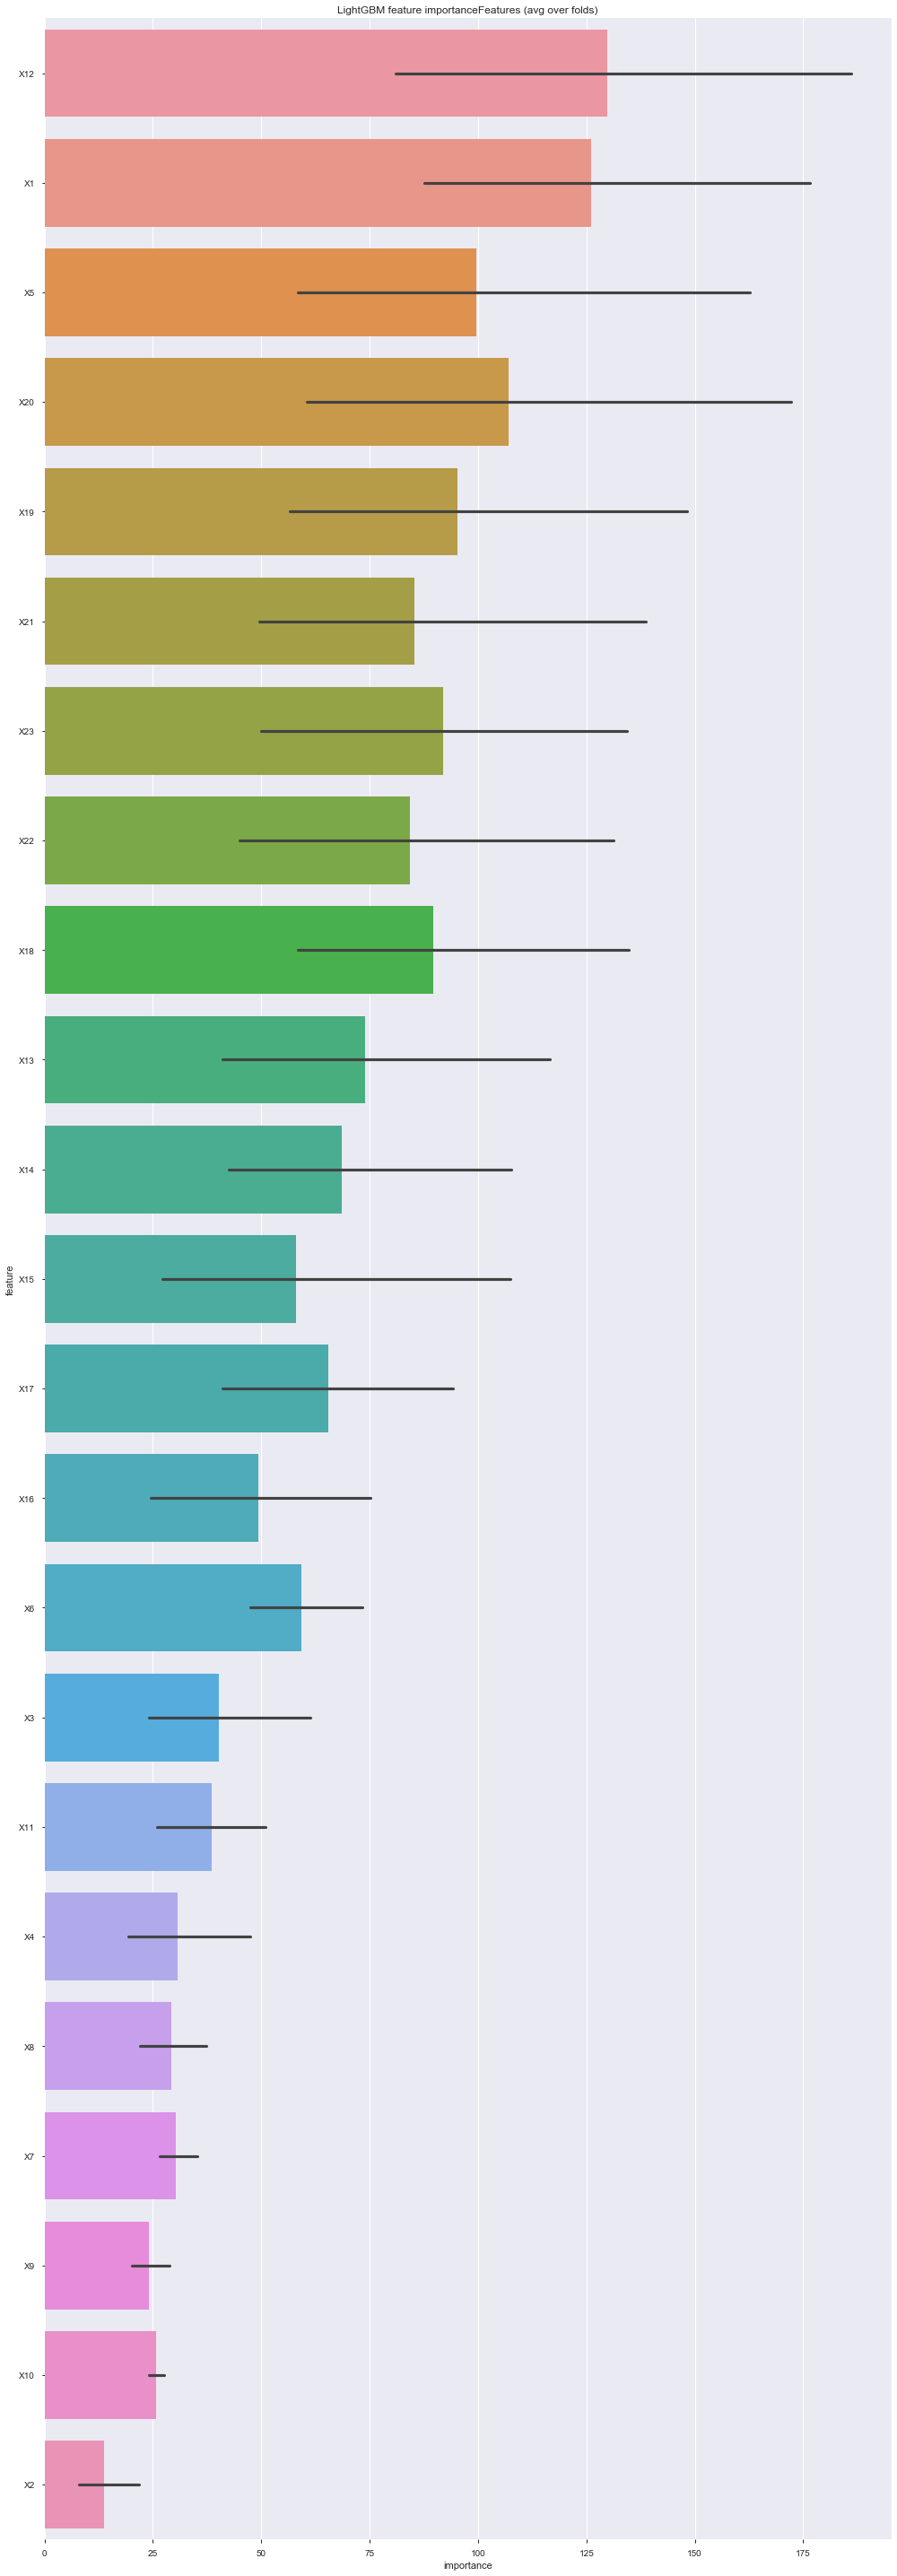

In [14]:
# parameters
tree_param = Process.open_parameter(file_name = 'Tree_classifer_param')
lgb_param = Process.open_parameter(file_name = 'lgb_classifer_param')
# features = test_new.columns.values
# model
lgb_base, importances_base = LightGBM.validation(train_base,features_base,lgb_param,name="Lightgbm base model")
# lgb_new, importances = LightGBM.validation(train_base,features_base,param,name="Lightgbm new model")
#lgb_new, importances_new = LightGBM.validation(train_new,features,lgb_param,name="Lightgbm new model")
tree_base = DecisionTree.validation(train_base,features_base,tree_param, name="Decision Tree base model")
#tree_new = DecisionTree.validation(train_new,features,tree_param, name="Decision Tree new model")

# result
#performance = pd.concat([lgb_base,lgb_new,tree_base,tree_new])
#g_normal = ggplot(performance,aes(x='fold',y='score',group = 'model',color = 'model')) + geom_point() + geom_line()
#print(g_normal)

# feature importance
LightGBM.display_importances(importances_base, title="LightGBM feature importance")

In [19]:
print(lgb_base)
print(lgb_new)

   fold                model     score
0     1  Lightgbm base model  0.495437
1     2  Lightgbm base model  0.482434
2     3  Lightgbm base model  0.478057
3     4  Lightgbm base model  0.469467
   fold               model     score
0     1  Lightgbm new model  0.477931
1     2  Lightgbm new model  0.484228
2     3  Lightgbm new model  0.463768
3     4  Lightgbm new model  0.467826


In [14]:
performance

,fold,model,score
0,1,Lightgbm base model,0.495437
1,2,Lightgbm base model,0.482434
2,3,Lightgbm base model,0.478057
3,4,Lightgbm base model,0.469467
0,1,Lightgbm new model,0.485249
1,2,Lightgbm new model,0.474783
2,3,Lightgbm new model,0.474839
3,4,Lightgbm new model,0.463478
0,1,Decision Tree base model,0.478222
1,2,Decision Tree base model,0.449578


In [16]:
features

array(['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'log_credit', 'boxcox_credit', 'scaler_credit', 'bins_ages',
       'nopay_count', 'pay_count', 'revo_count', 'late_count',
       'log_pay_9', 'log_pay_8', 'log_pay_7', 'log_pay_6', 'log_pay_5',
       'log_pay_4', 'log_prepay_9', 'log_prepay_8', 'log_prepay_7',
       'log_prepay_6', 'log_prepay_5', 'log_prepay_4', 'X2_X2', 'X2_X3',
       'X2_X4', 'X3_X3', 'X3_X4', 'X4_X4'], dtype=object)